# Assumptions
- Treat the dataset belongs to one shop
- lat and long are referred to the place that the customer is from

# Main Question1: What factors contribute to the change of the total money spent by customer?
# Main Question2: What are the frequent types of customer who like to do laundry for blankets or clothes?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from apyori import apriori
from scipy.stats import chi2_contingency
from scipy.stats import wilcoxon
from boruta import BorutaPy
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import StackingRegressor, StackingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import shap
import pickle


In [2]:
# Helper functions
def checkMissingData(df):
    totalMissingData = df.isnull().sum()
    totalMissingData = totalMissingData[totalMissingData > 0]
    print(totalMissingData)
    print(f"Largest number of rows that have missing data: {totalMissingData.nlargest(1).values[0]}")
    print(f"Smallest number of rows that have missing data: {totalMissingData.nsmallest(1).values[0]}")


    
def check_unique_values(df, cols):
    for col in cols:
        unique_values = df[col].unique()
        print(f'Unique values for column "{col}": {unique_values}')

def check_positive(df):
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns

    for col in num_cols:
        print(f'column "{col}": ', end="")
        if df[col].lt(0).any():
            print("not ", end="")
        print("always positive")

def check_outliers(df, num_cols):    
    for col in num_cols:
        plt.figure(figsize=(5, 5))
        plt.title(col)
        sns.boxplot(data=df[col])
        
def preprocess_time(x):
    if ';' in x:
        x = x.replace(';', ':')
        return x
    return x

def convert_dt(x):
    dt_split = x.split('/')
    d, m, y = dt_split[0], dt_split[1], dt_split[2]
    return f"{y}-{m}-{d}"

In [3]:
# Read data and combine external datasets
df = pd.read_csv("dataset.csv")
location_df = pd.read_csv("location_data.csv")
weather_df = pd.read_csv("weather_data.csv")
primary_keys = ['latitude', 'longitude']
df = pd.merge(df,location_df, on=primary_keys)
df = pd.merge(df,weather_df, on=primary_keys)
df['Formatted_Date'] = df['Date'].apply(lambda x:convert_dt(x))
df['Time'] = df['Time'].apply(lambda x: preprocess_time(x))
df['Datetime'] = pd.to_datetime(df['Formatted_Date'] + ' ' + df['Time'])

In [4]:
display(df[df["With_Kids"] == "yes"]['Kids_Category'].value_counts())
display(df[df["With_Kids"] == "no"]['Kids_Category'].value_counts())

# "With_Kids" conflicts with 'Kids_Category'. We will keep only 'Kids_Category' as it is more dominat

young       386
toddler     347
baby        336
no_kids     330
toddler     302
Name: Kids_Category, dtype: int64

no_kids     872
young       316
toddler     313
baby        297
toddler     289
Name: Kids_Category, dtype: int64

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


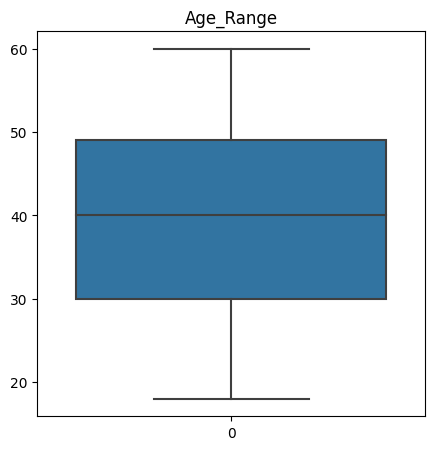

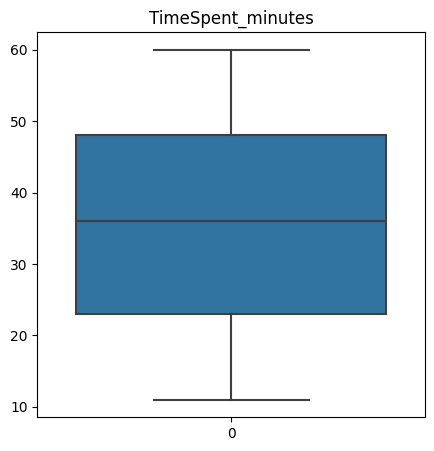

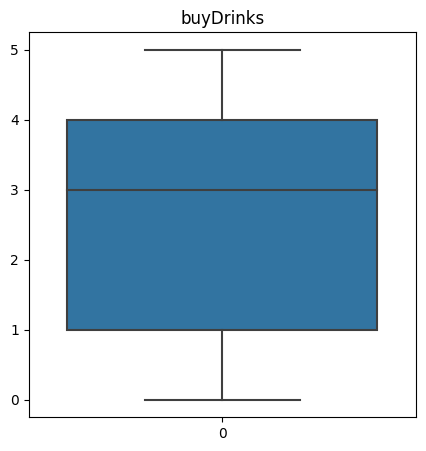

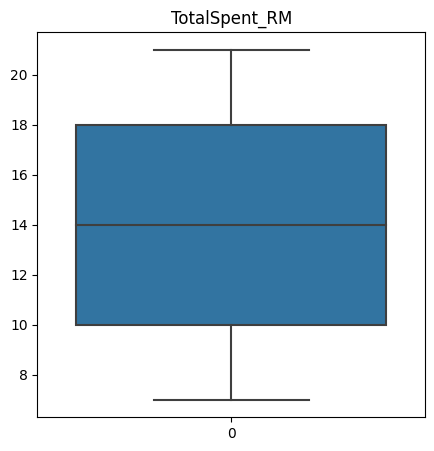

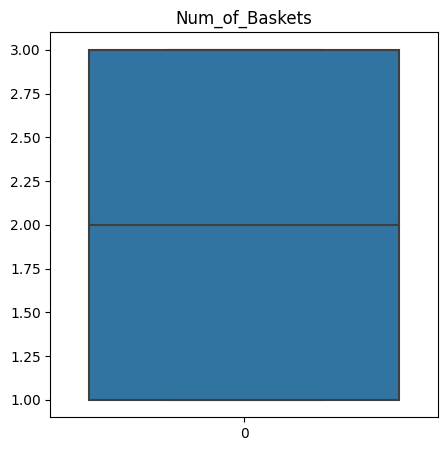

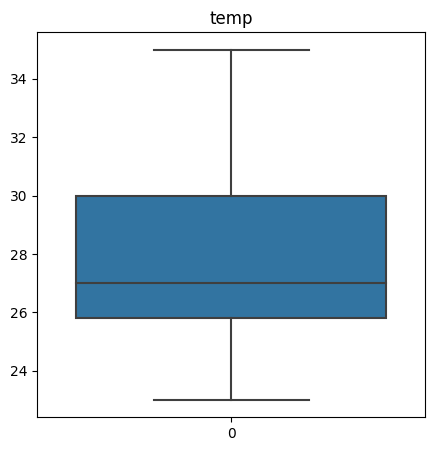

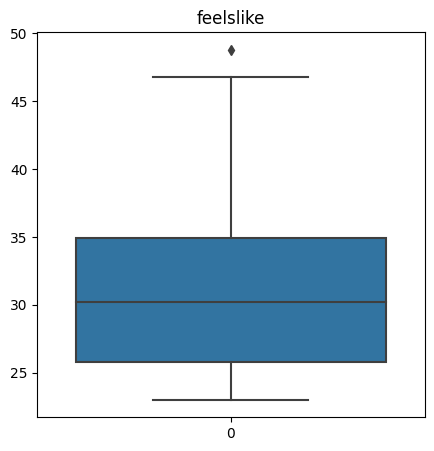

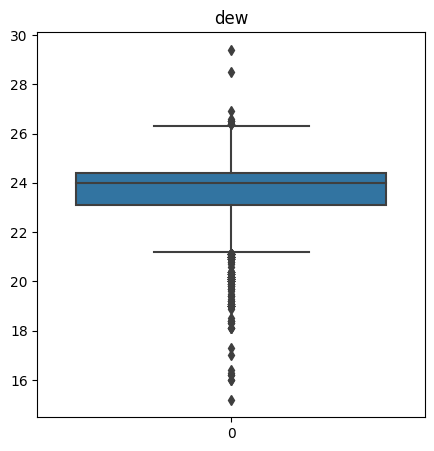

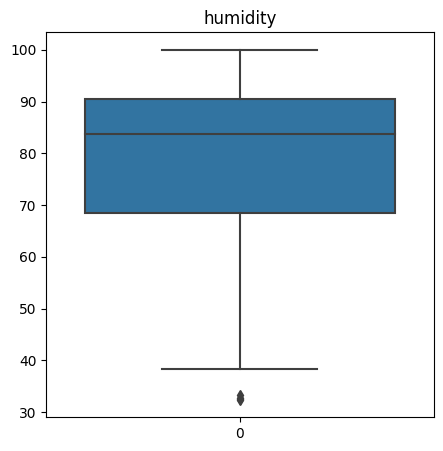

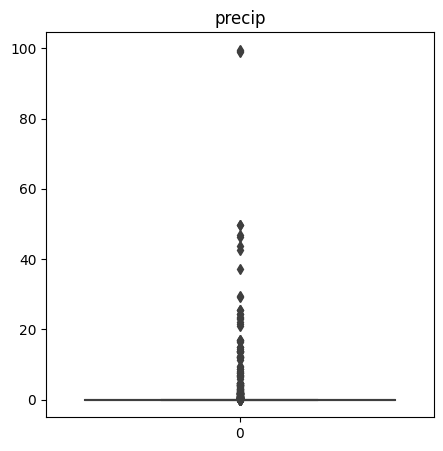

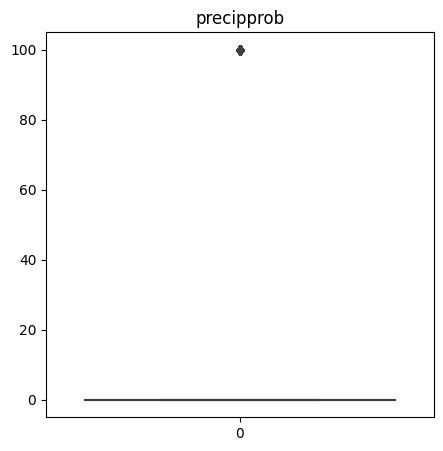

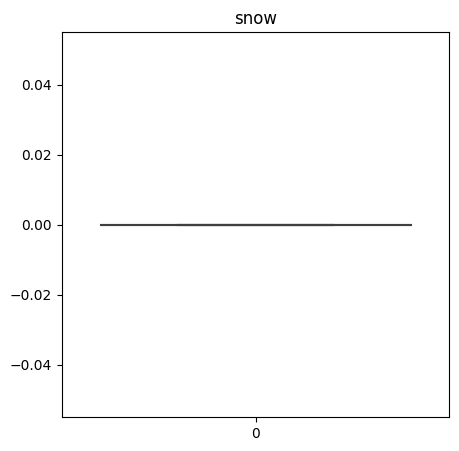

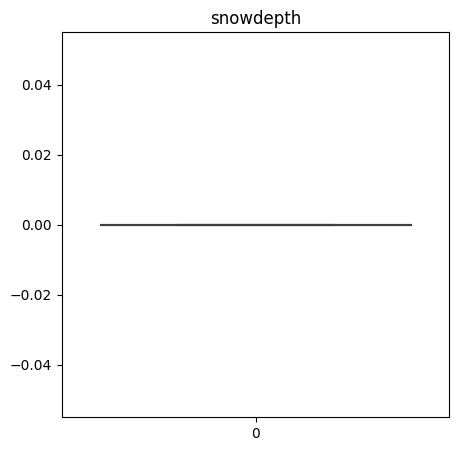

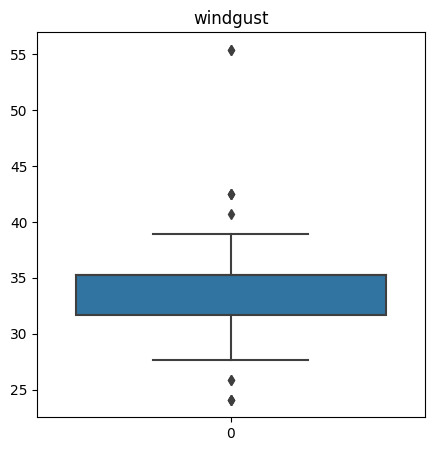

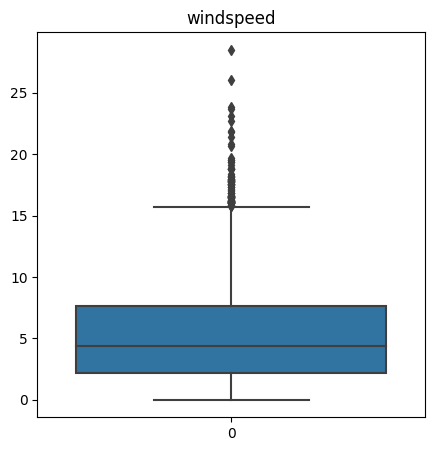

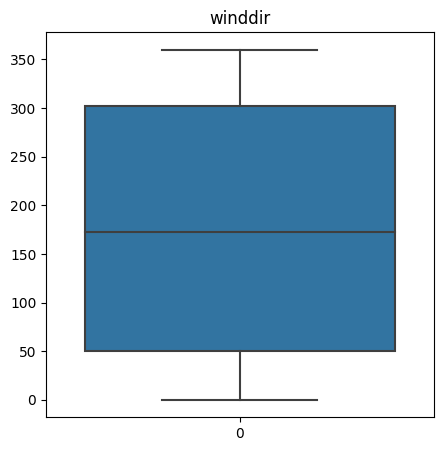

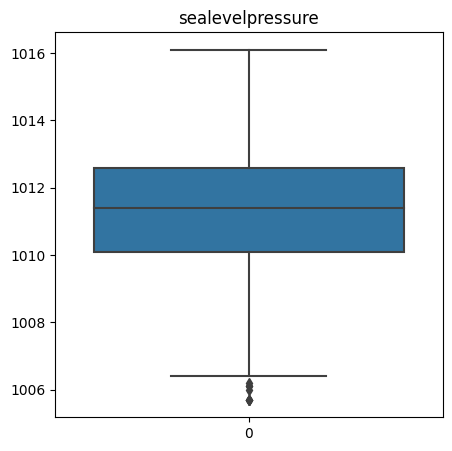

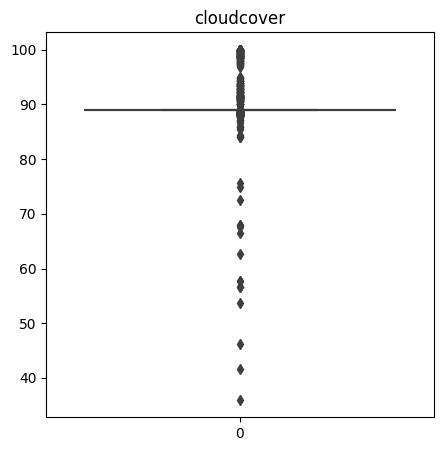

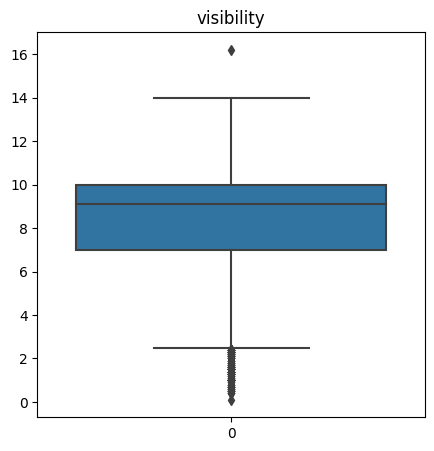

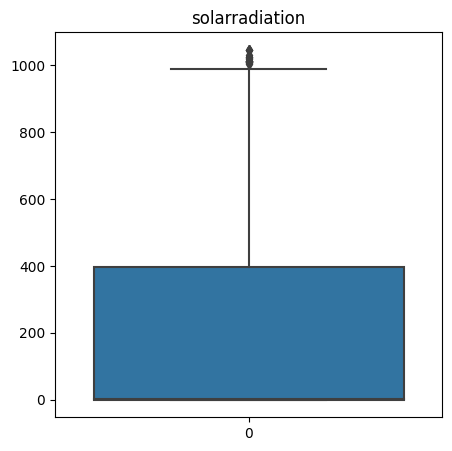

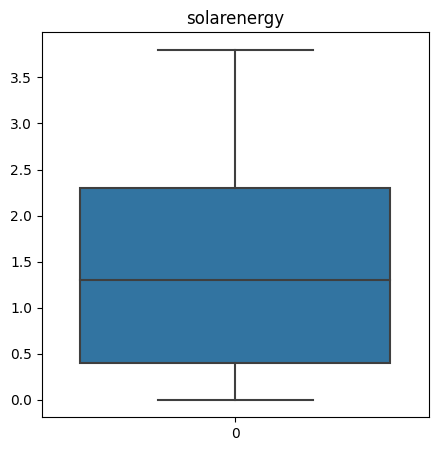

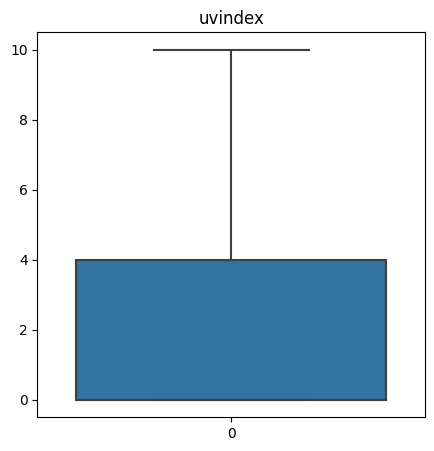

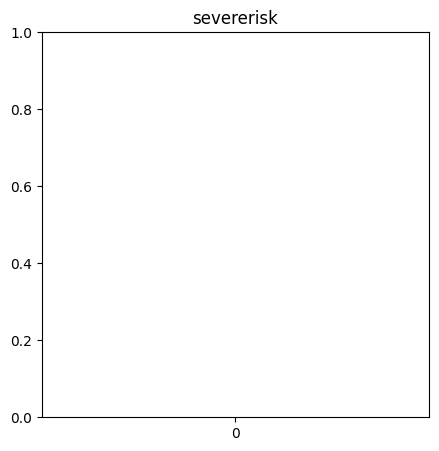

In [5]:
cols = list(df.select_dtypes(include=['int64', 'float64']).columns)
col_to_remove = ["latitude", "longitude", "Washer_No", "Dryer_No", "Postcode"]

for e in col_to_remove:
    cols.remove(e)
 
check_outliers(df, cols)

In [6]:
checkMissingData(df)

Race                  198
Gender                177
Body_Size             183
Age_Range             143
With_Kids             186
Kids_Category          30
Basket_Size           205
Basket_colour         203
Attire                217
Shirt_Colour          174
shirt_type            185
Pants_Colour          174
pants_type              9
Wash_Item             181
Spectacles            209
TimeSpent_minutes      69
buyDrinks              35
TotalSpent_RM          54
Num_of_Baskets        182
preciptype           3806
snow                    7
snowdepth               7
windgust             3967
sealevelpressure     2674
visibility              7
solarenergy          1860
severerisk           4000
dtype: int64
Largest number of rows that have missing data: 4000
Smallest number of rows that have missing data: 7


In [7]:
# Data cleaning

# Set Race
df.loc[df["Race"] == "foreigner ", "Race"] = "foreigner"

# Set toddler
df.loc[df["Kids_Category"] == "toddler ", "Kids_Category"] = "toddler"

# Set Basket_color
df.loc[df["Basket_colour"] == "black ", "Basket_colour"] = "black"

# Set shirt_type
df.loc[df["shirt_type"] == "long sleeve", "shirt_type"] = "long_sleeve"

# Set Shirt_Colour
df.loc[df["Shirt_Colour"] == "black ", "Shirt_Colour"] = "black"

# Set Pants_Colour
df.loc[df["Pants_Colour"].isin(['blue ', 'blue  ', 'blue_jeans']), "Pants_Colour"] = "blue"
df.loc[df["Pants_Colour"] == "black ", "Pants_Colour"] = "black"

df["isRain"] = df["preciptype"] == "rain"

#With kids and Unknown kids type as "yes"
df.loc[(df["With_Kids"] == "yes") & (df["Kids_Category"].isna()), "Kids_Category"] = "yes"

#Without kids and Unknown kids type as "no_kids"
df.loc[(df["With_Kids"] != "yes") & (df["Kids_Category"].isna()), "Kids_Category"] = "no_kids"

df["DayOfWeek"] = df["Datetime"].apply(lambda x : x.weekday())
df["HourInDay"] = df["Datetime"].apply(lambda x : x.hour)


# Drop cols that has too many NA values and feature columns that are unnecessary
many_na_cols = ["severerisk", "solarenergy", "windgust", "sealevelpressure"]
unnecessary_cols = ["preciptype","With_Kids", "snow", "snowdepth","precipprob", "precip","feelslike",
                    "visibility", "winddir", "uvindex", "solarenergy", "solarradiation", "stations", "icon",
                    "dew", "cloudcover"
                   ]
drop_cols = many_na_cols + unnecessary_cols
df.drop(columns=drop_cols, inplace=True)
df.rename(columns = {'temp':'Temperature'}, inplace = True)
df.dropna(inplace=True)

df.reset_index(drop=True, inplace=True)
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2574 entries, 0 to 2573
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               2574 non-null   object        
 1   Time               2574 non-null   object        
 2   Race               2574 non-null   object        
 3   Gender             2574 non-null   object        
 4   Body_Size          2574 non-null   object        
 5   Age_Range          2574 non-null   float64       
 6   Kids_Category      2574 non-null   object        
 7   Basket_Size        2574 non-null   object        
 8   Basket_colour      2574 non-null   object        
 9   Attire             2574 non-null   object        
 10  Shirt_Colour       2574 non-null   object        
 11  shirt_type         2574 non-null   object        
 12  Pants_Colour       2574 non-null   object        
 13  pants_type         2574 non-null   object        
 14  Wash_Ite

None

- How we handle outliers
    - For handling outliers, we will drop the columns that has extremely high outliers and use machine learning model that are robust for dealing outliers in the prediction task
- Reasons of dropping columns
    - "preciptype": Has been used for constructing "isRain" column
    - "With_Kids": Inconsistent respect to "Kids_Category", Has been used for filling NA value of "Kids_Category"
    - "snow": No snow in Malaysia
    - "snowdepth": No snow in Malaysia
    - "precipprob": This value is derived using forecasting, we would prefer the actual condition of the weather
    - "feelslike","precip","visibility", "winddir", "uvindex", "solarenergy", "solarradiation", "stations": Unnecessary or not easily intepretable
    - "icon": Redundant with "conditions"
    - "dew", "cloudcover": The number of outliers are extremely high and will introduce too much noise to the modelling and not suittable for analysis

-  How we handle missing values after dropping unused columns
    - For handling missing values, we have chosen to drop the rows that have null value as we would not like to use mean value, median value to impute the missing value as it will introduce fake data whereby we would like to keep our analysis as valid as possible. Imputation will also change or bring distortion in the original variance. For categorical column, there is also no way for us to manually impute the missing values.

# Exploratory Data Analysis

In [8]:
# helper functions
GLOBALPALETTE = "Set1"

def customCountPlot(data, ax=None):
    totalCount = len(data)
    ax = sns.countplot(x=data, order=sorted(data.unique()), palette=GLOBALPALETTE,ax=ax)
    for p in ax.patches: 
        percentage = round((p.get_height() / totalCount) * 100,2)
        ax.annotate(f'{percentage}%',(p.get_x()+0.3, p.get_height()+10))

def plotUnivariateFeature(colName, isContinuous, df, ax=None,bins=None):
    # Ignore rows that has missing data on specific column
    data = df.loc[df[colName].notnull(), colName]
    if isContinuous:
        if bins != None:
            sns.histplot(data, ax=ax,bins=bins)
        else:
            sns.histplot(data, ax=ax)
    else:
        customCountPlot(data,ax)
        
def plotPostcode(df, ax=None):
    colName = "Postcode"
    # Ignore rows that has missing data on specific column
    data = df.loc[df[colName].notnull(), colName]
    
    fig, (ax) = plt.subplots(1,1,figsize=(30,17))
    ax.set_title(f"Counts for {colName}")
    plt.xticks(rotation=90)
    
    totalCount = len(data)
    ax = sns.countplot(x=data, order=sorted(data.unique()), palette=GLOBALPALETTE,ax=ax)

#### Univariate Analysis for Categorical Data

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


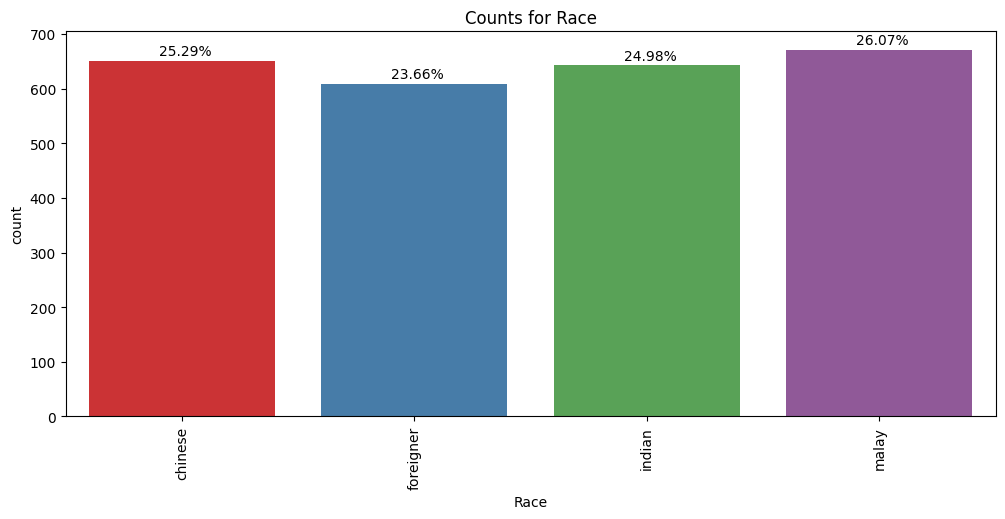

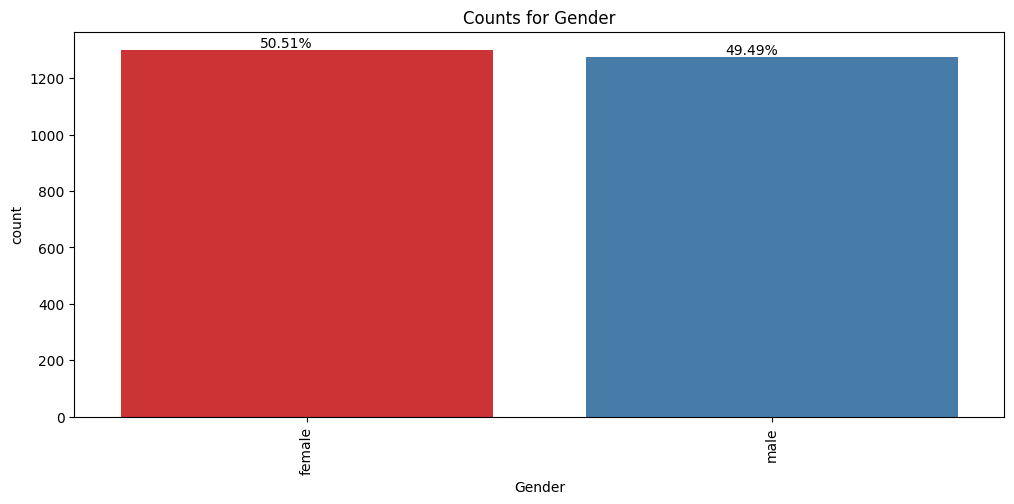

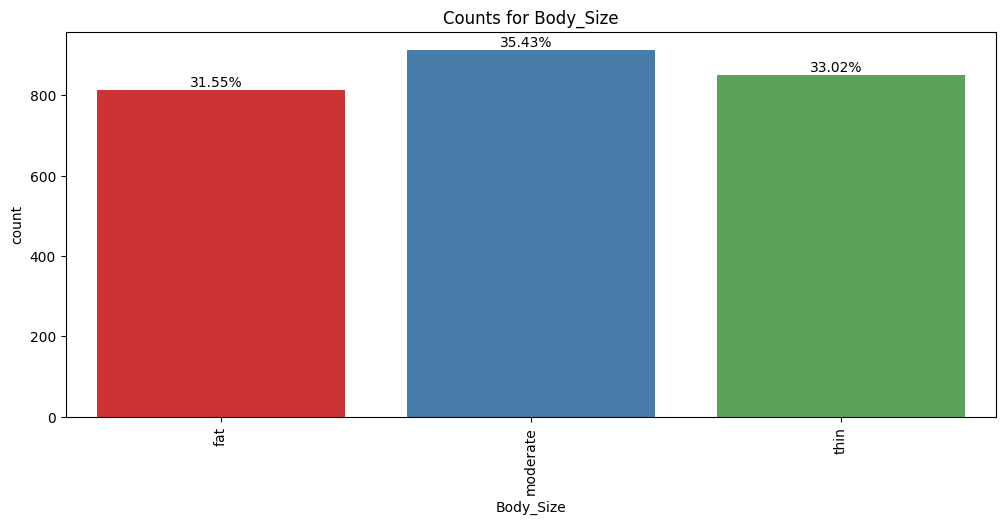

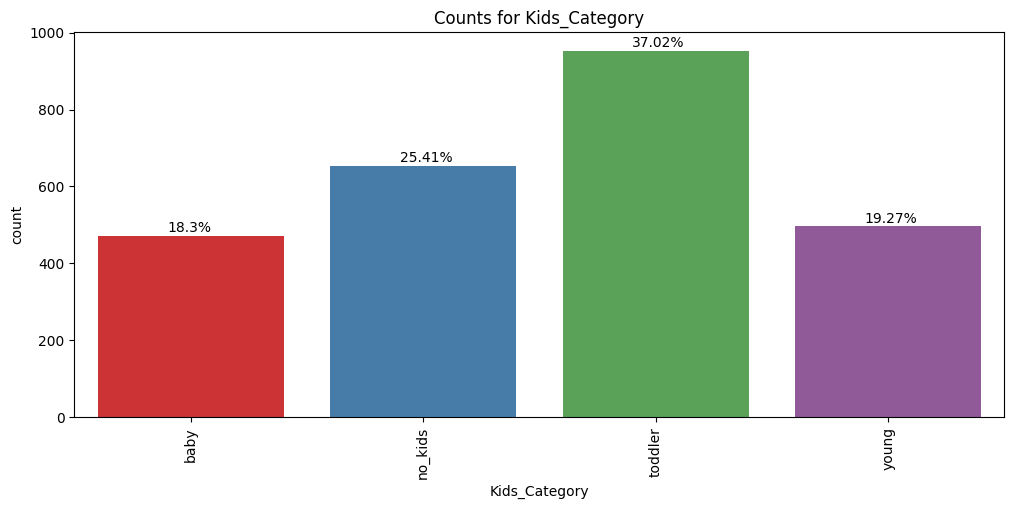

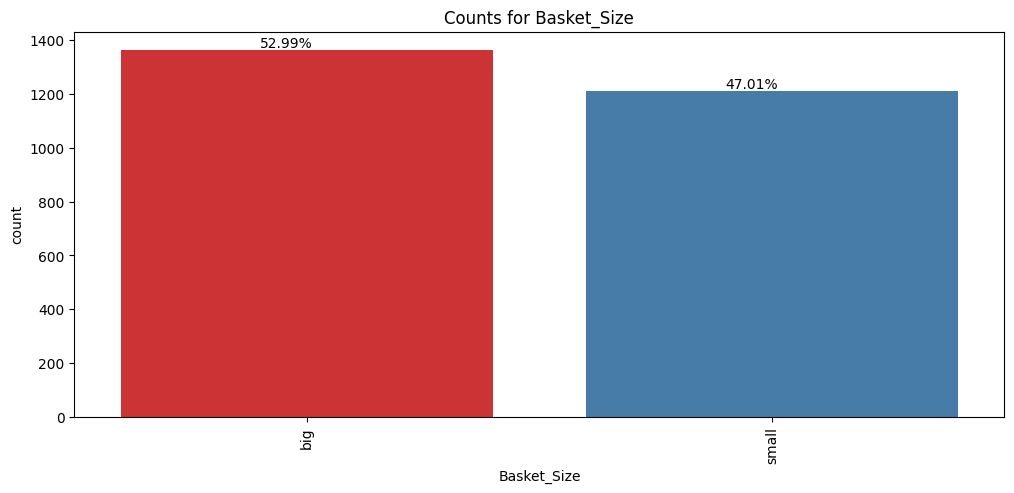

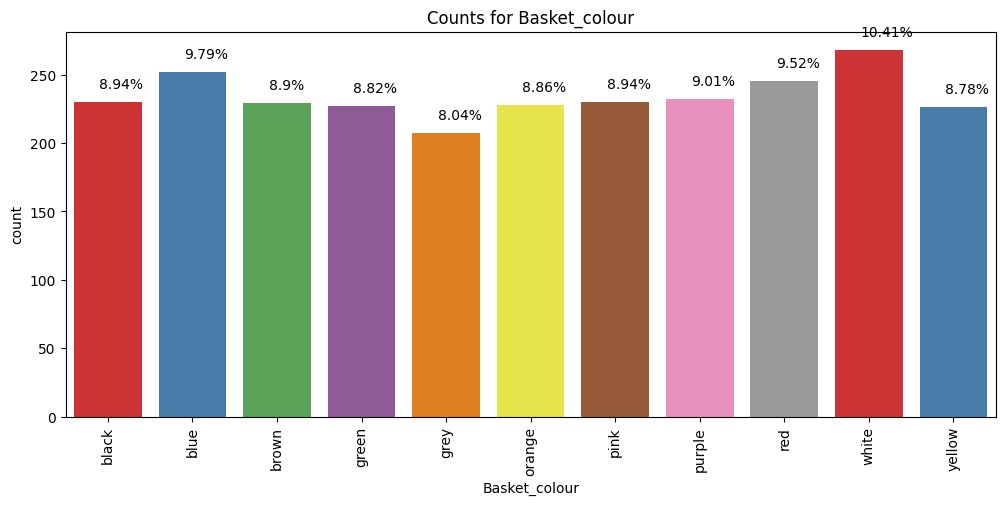

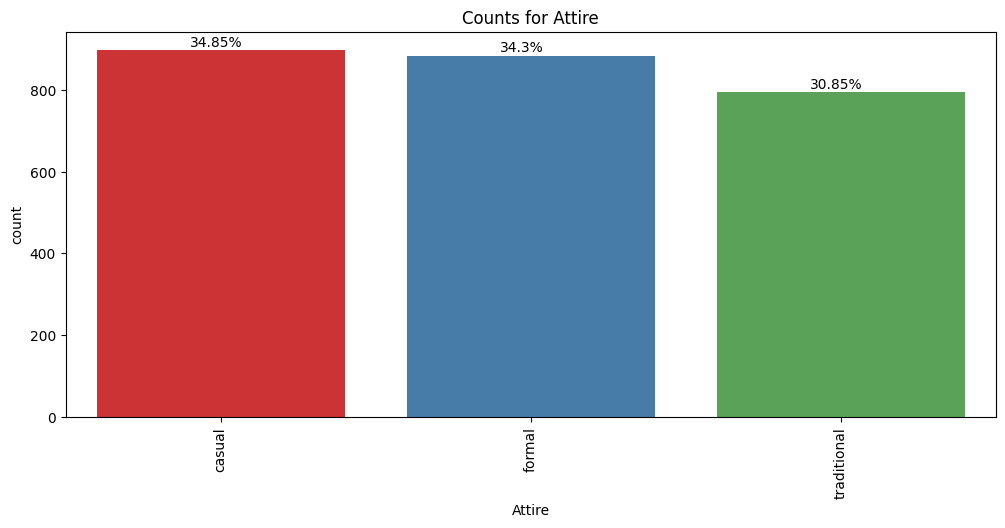

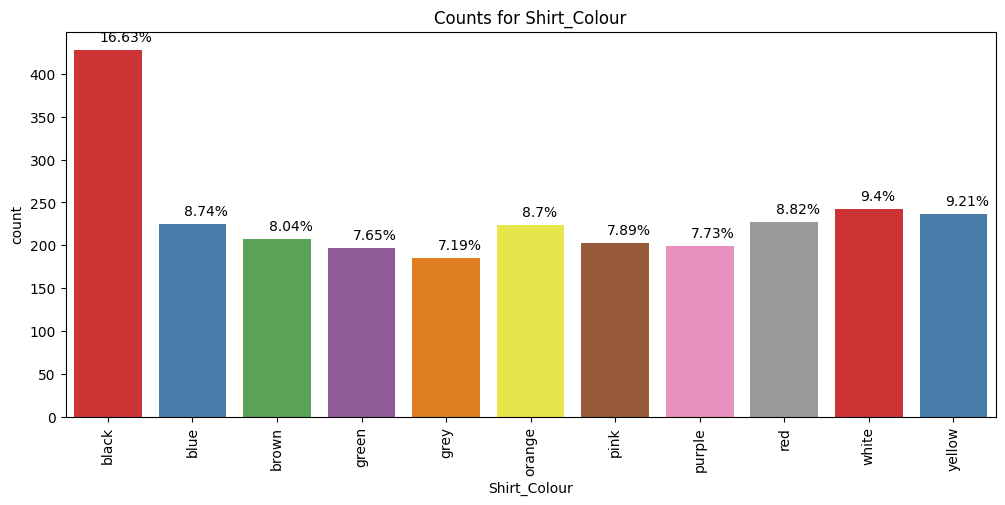

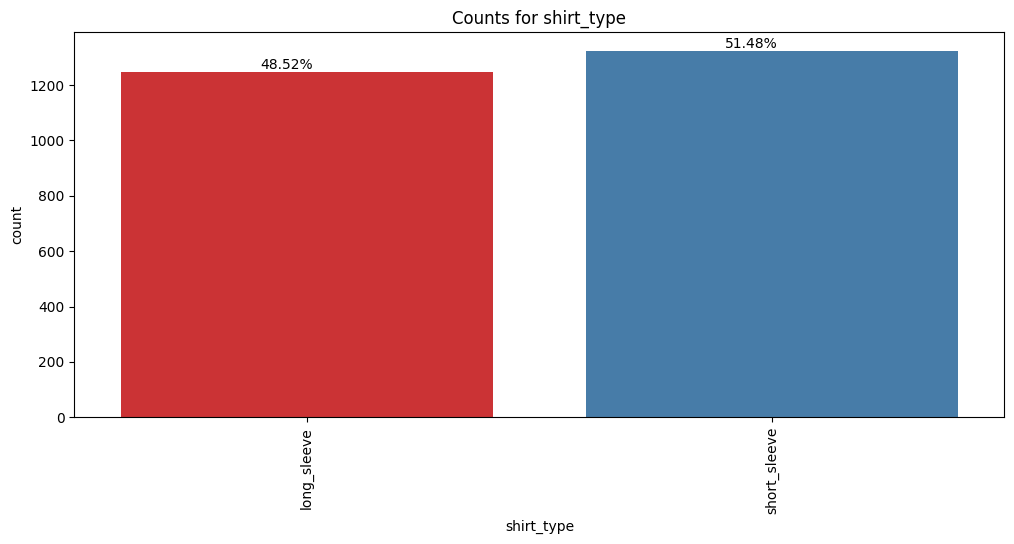

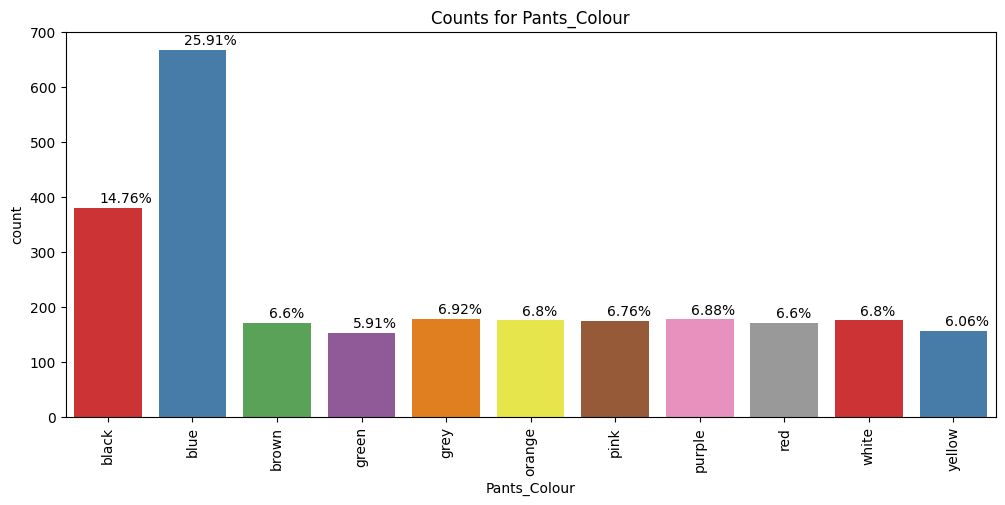

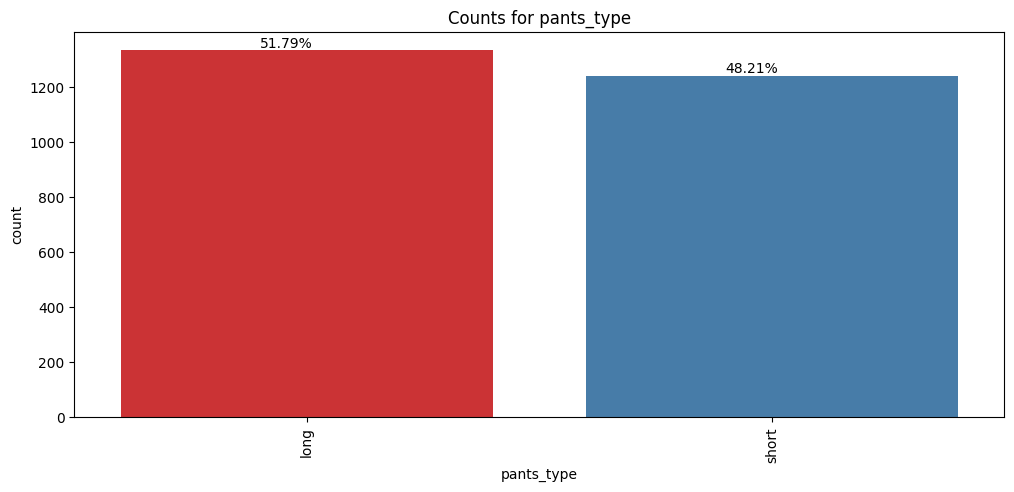

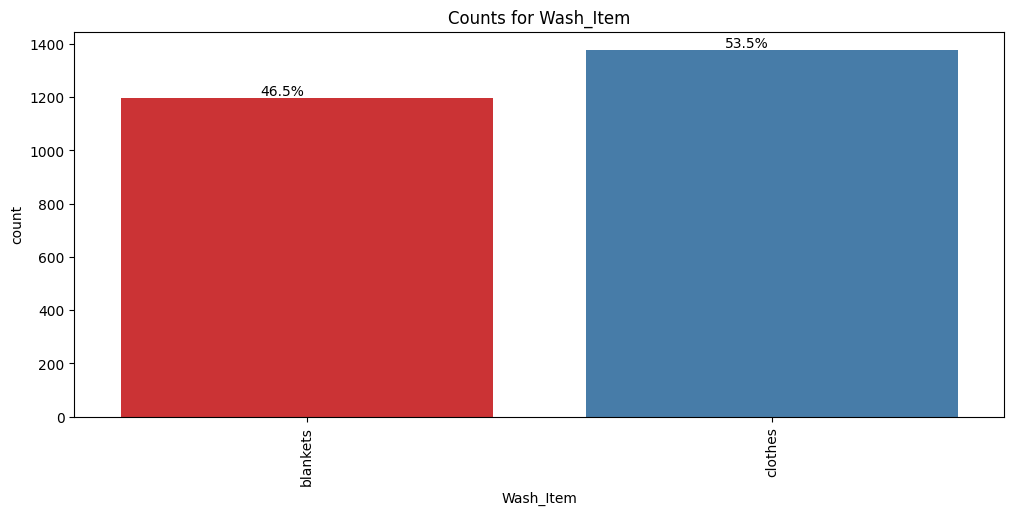

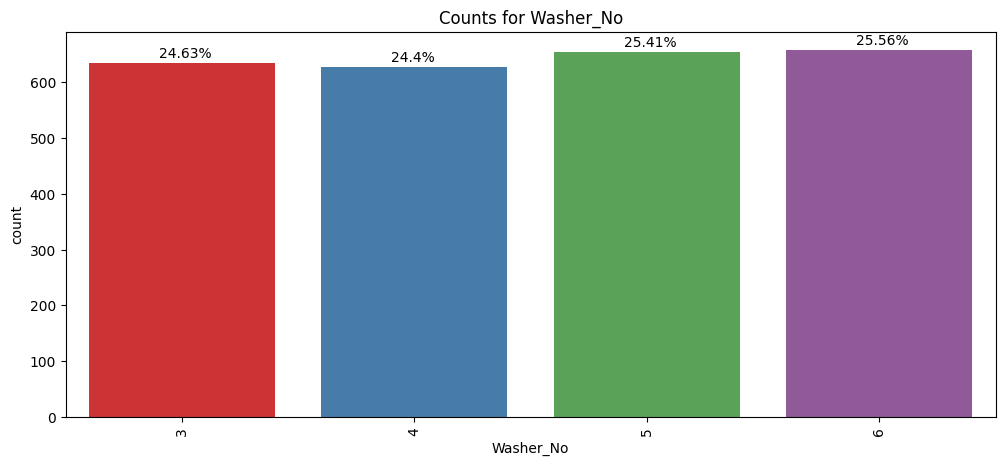

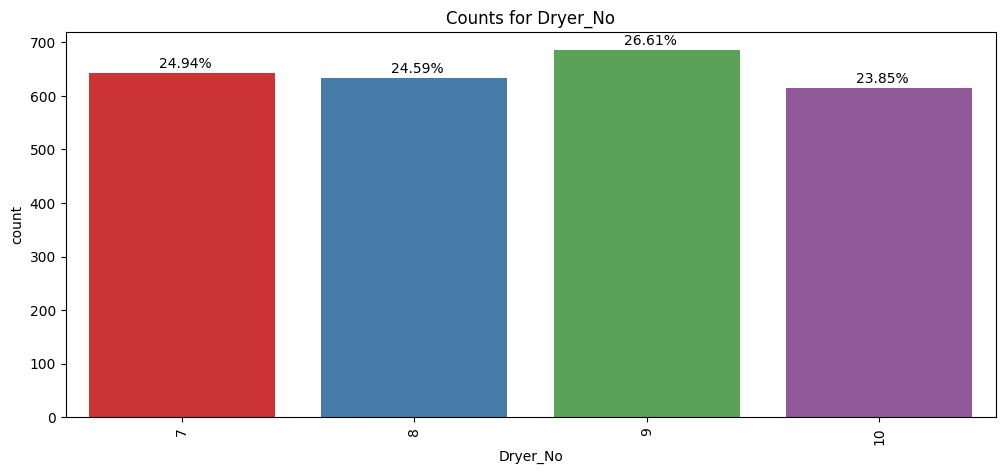

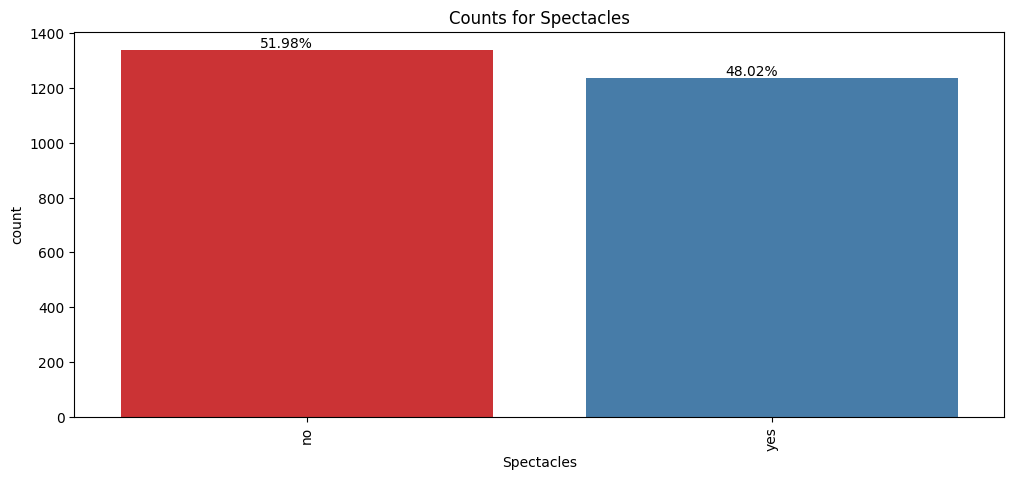

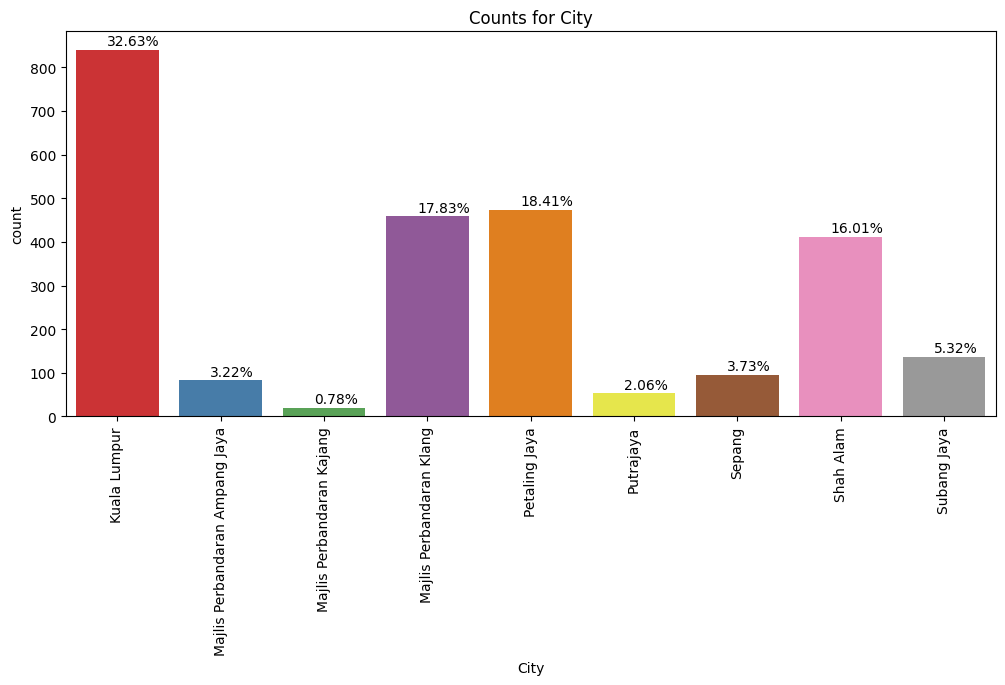

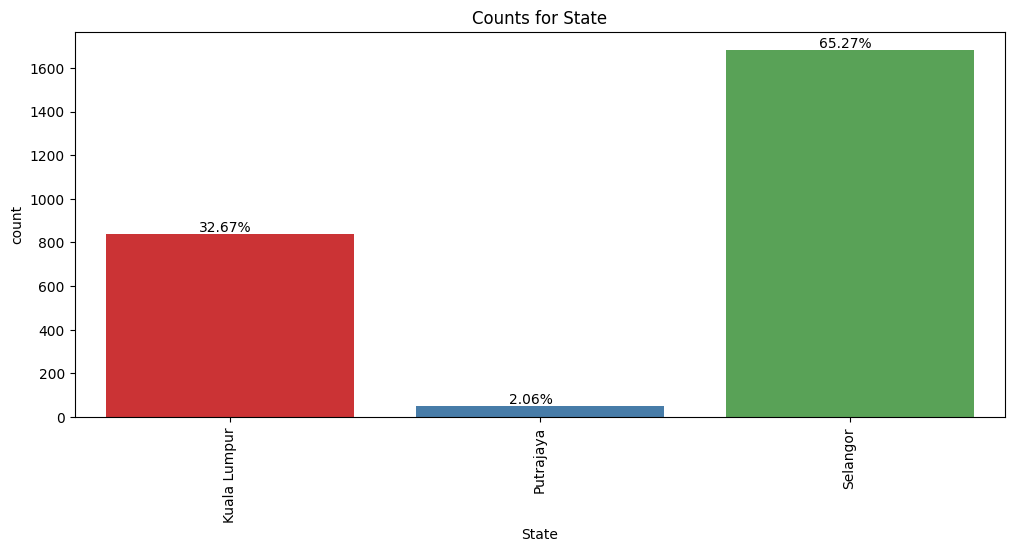

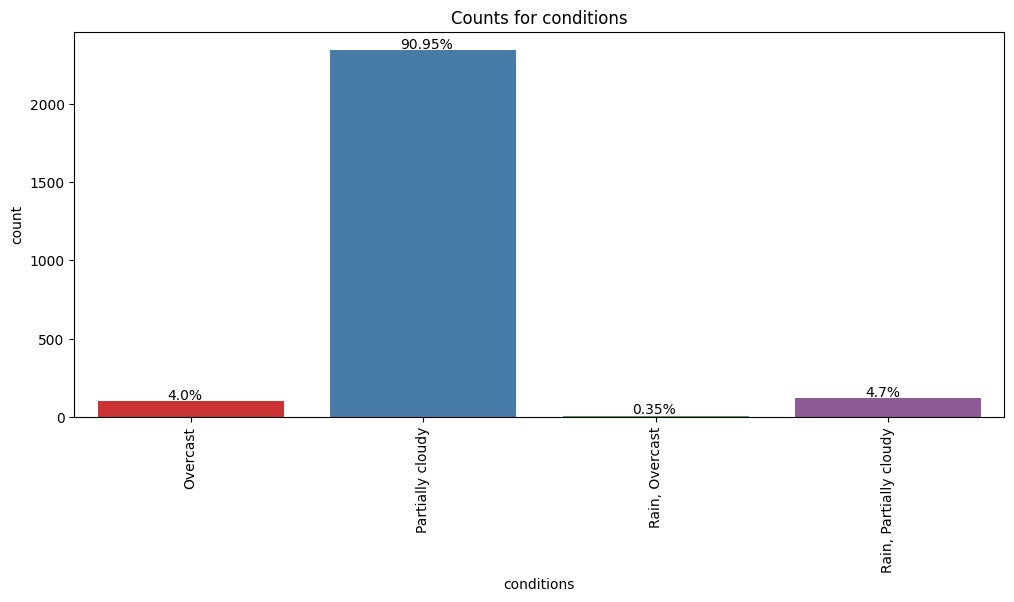

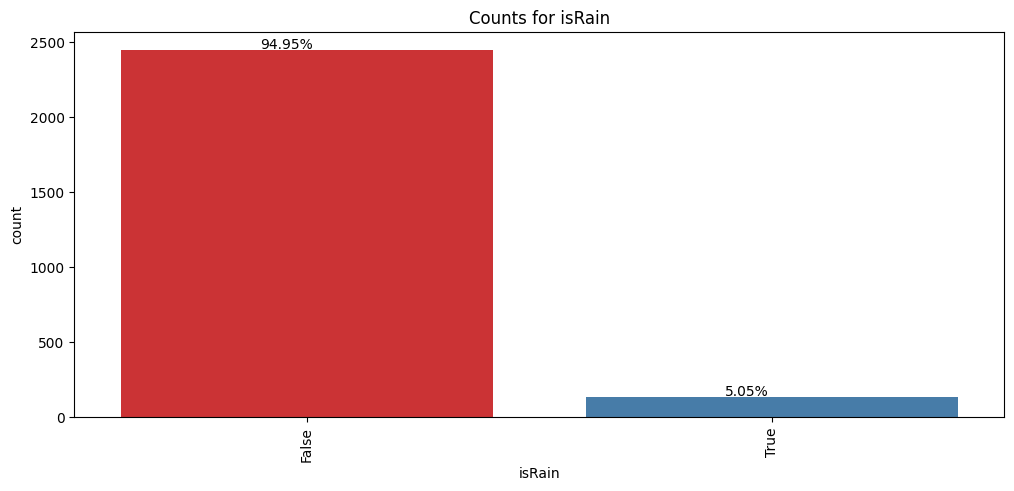

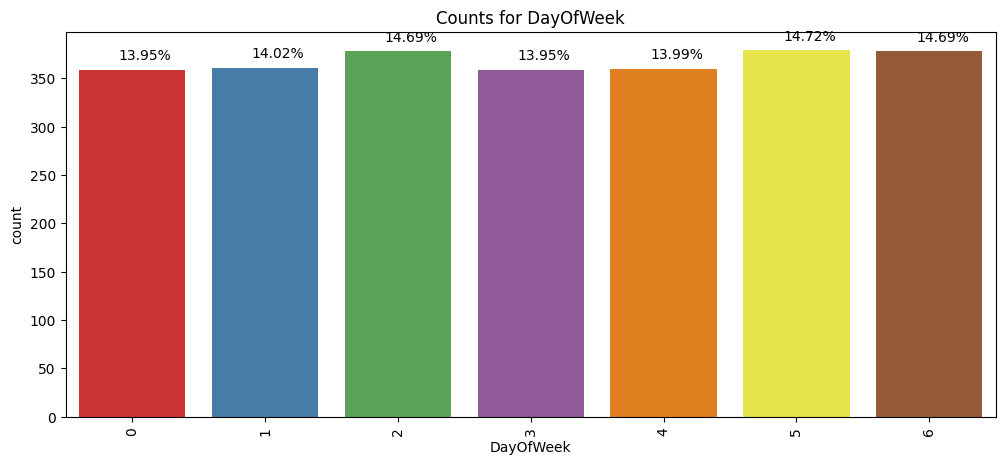

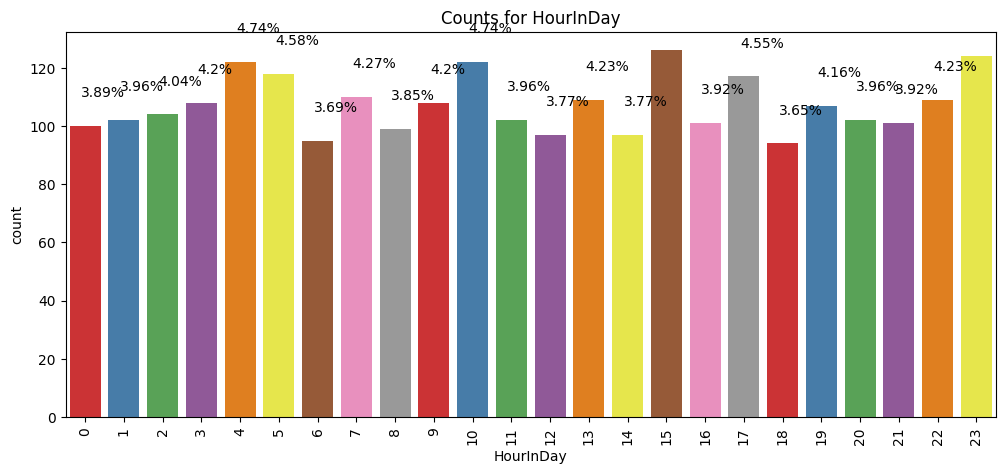

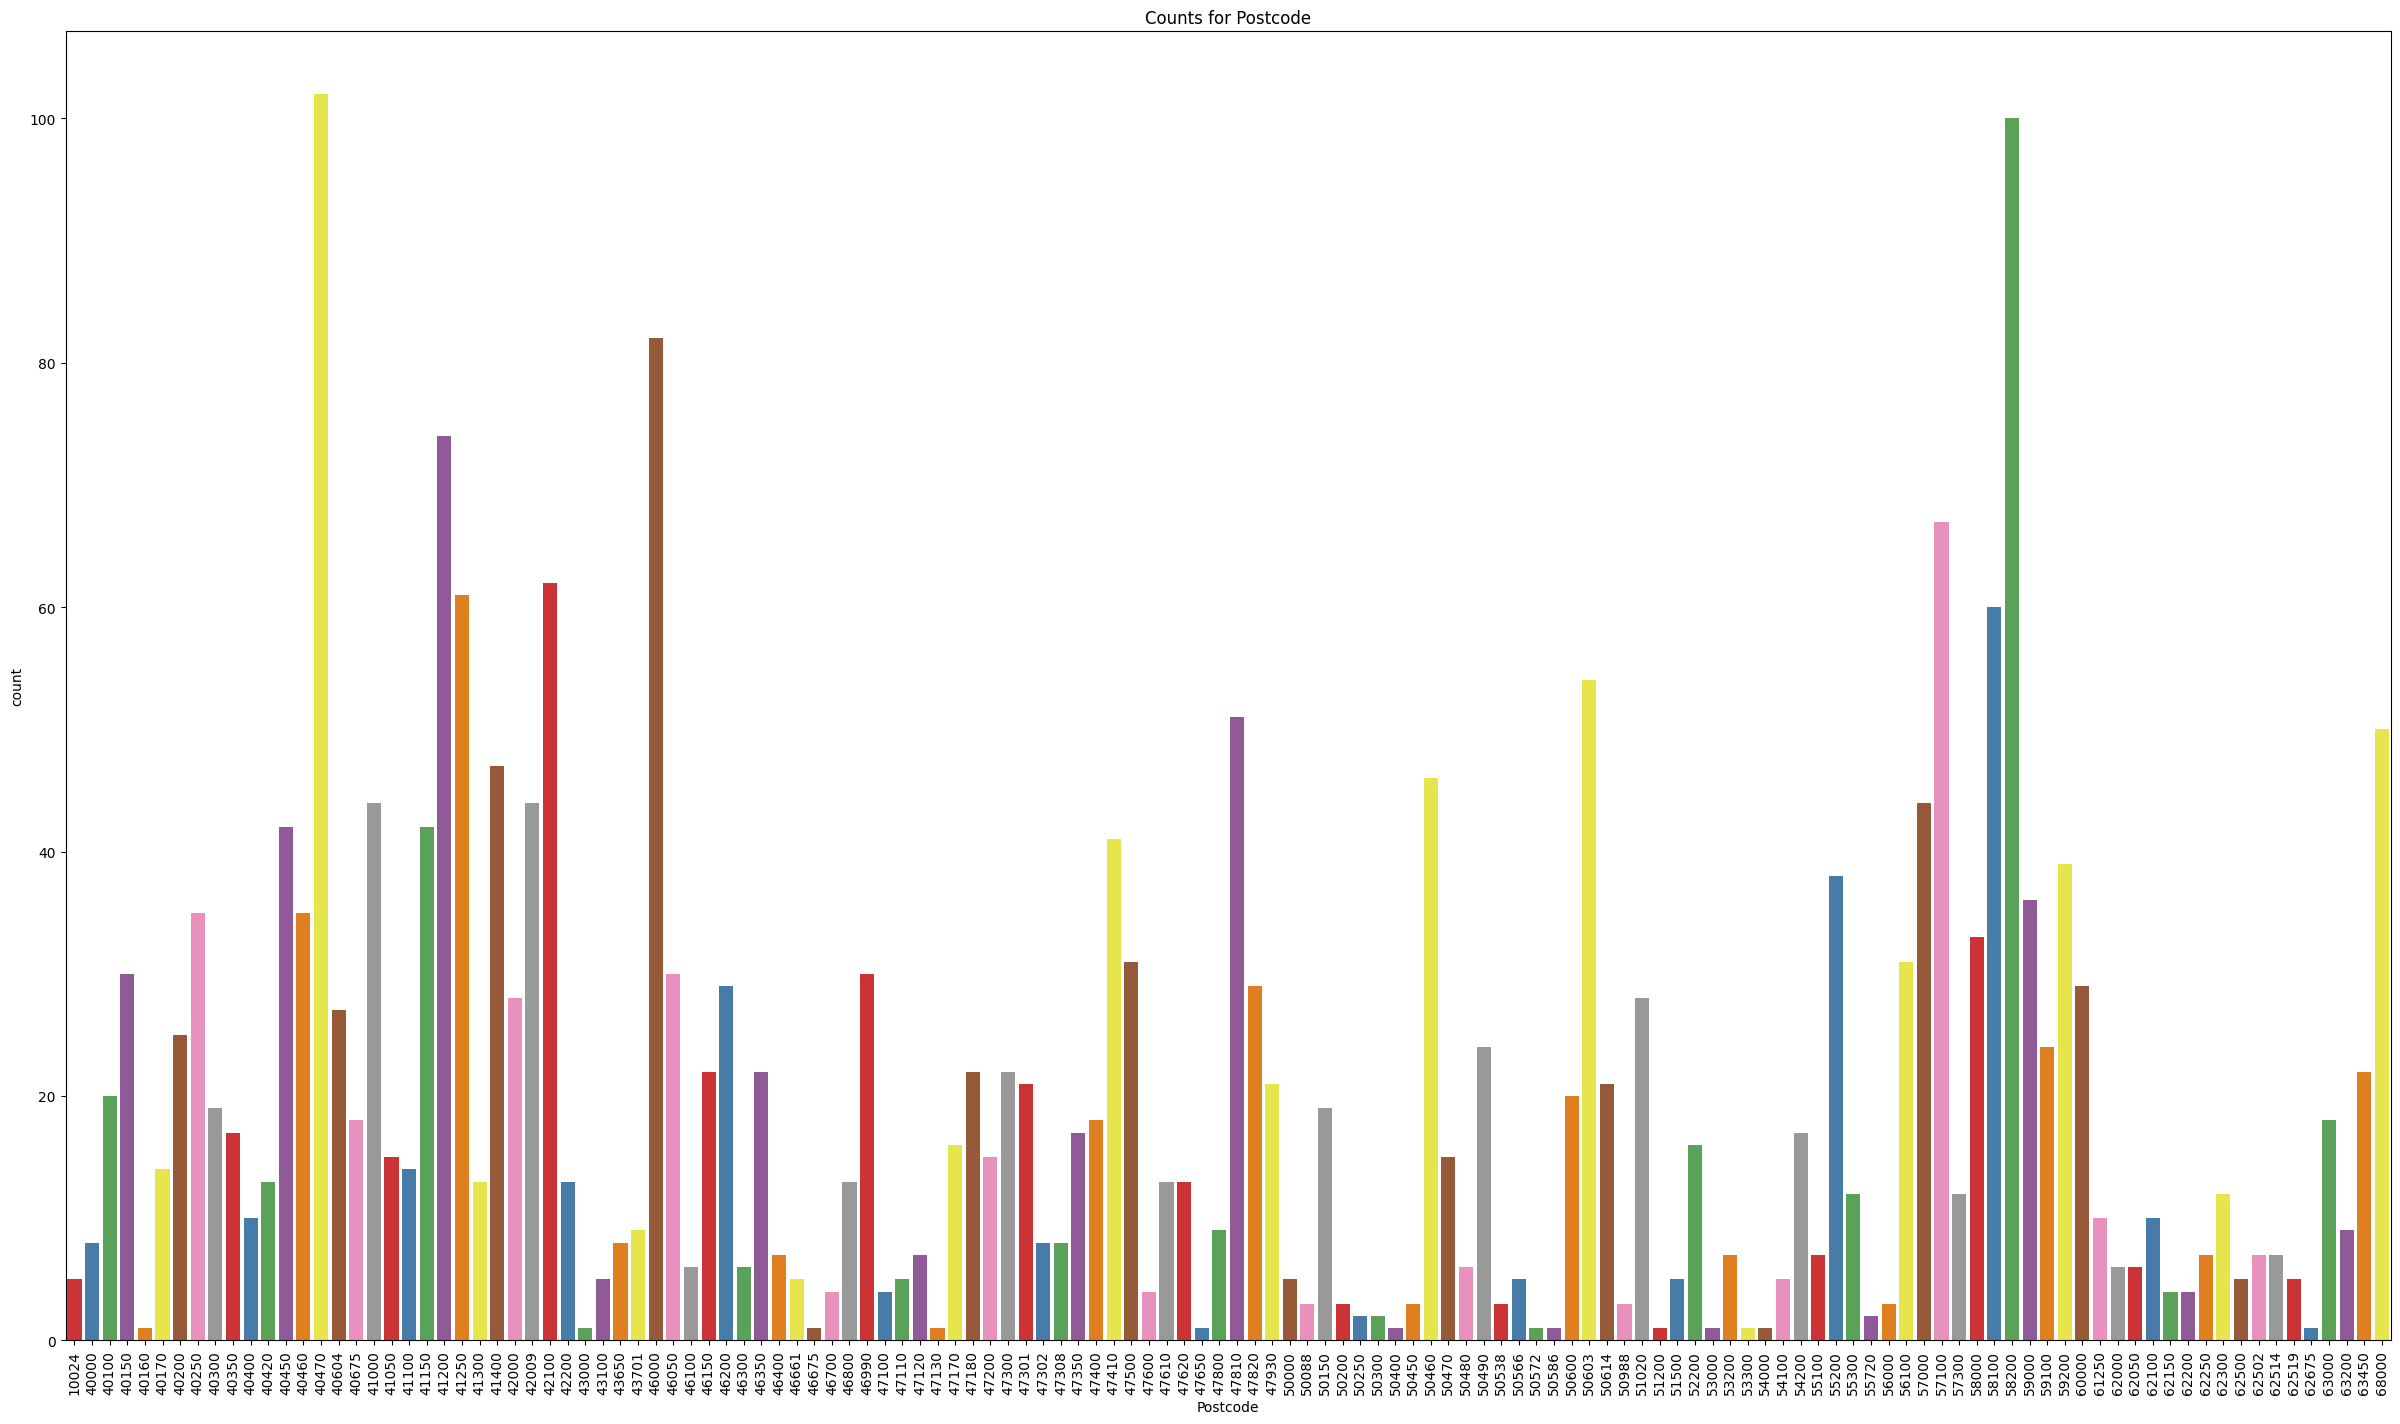

In [9]:
categoricalColumns = ['Race', 'Gender', 'Body_Size', 'Kids_Category', 'Basket_Size', 'Basket_colour', 'Attire',
                    'Shirt_Colour', 'shirt_type', 'Pants_Colour', 'pants_type', 'Wash_Item',
                    'Washer_No', 'Dryer_No', 'Spectacles', 'City', 'State',
                     'conditions', 'isRain', 'DayOfWeek', 'HourInDay'
                    ]

for colName in categoricalColumns:
    fig, (ax) = plt.subplots(1,1,figsize=(12,5))
    ax.set_title(f"Counts for {colName}")
    plt.xticks(rotation=90)
    plotUnivariateFeature(colName,False,df,ax)
    
plotPostcode(df)

#### Univariate Analysis for Numerical Data

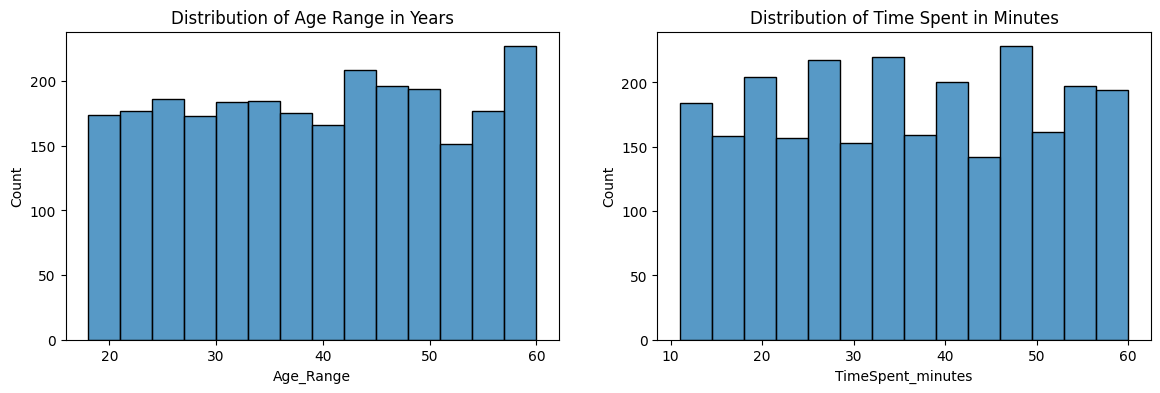

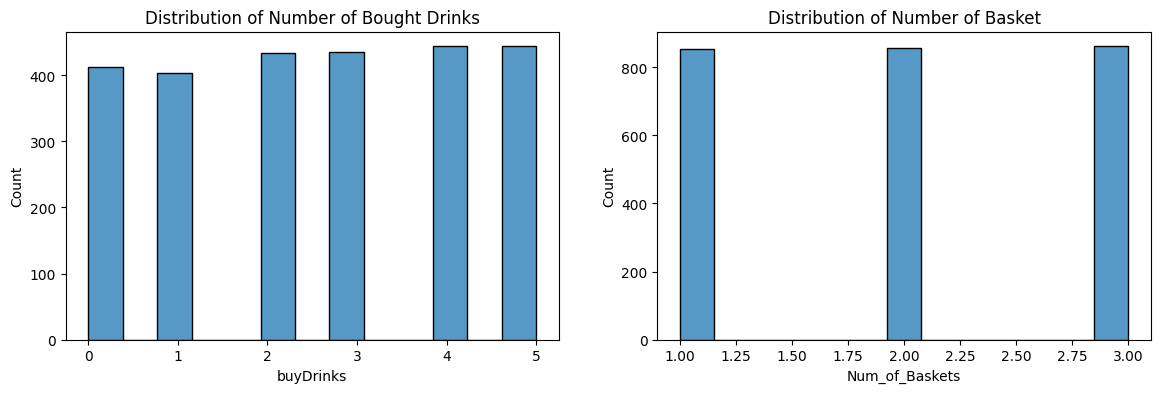

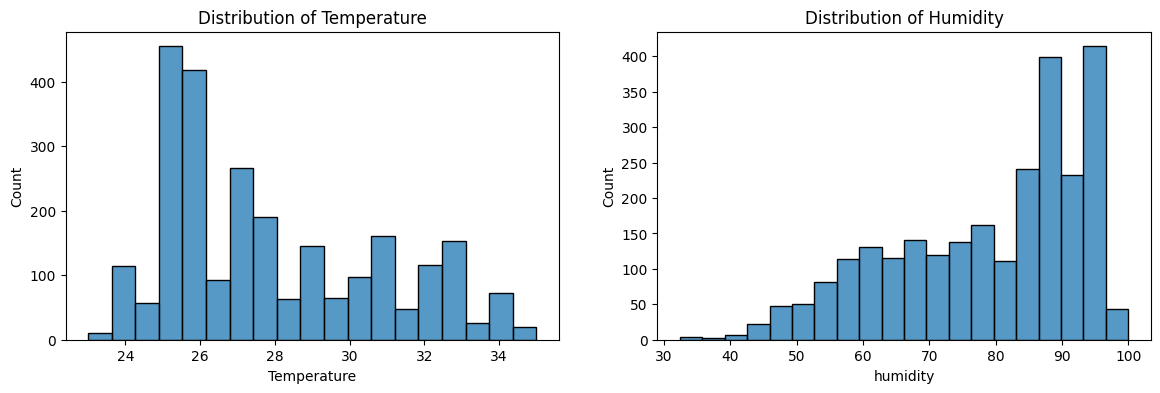

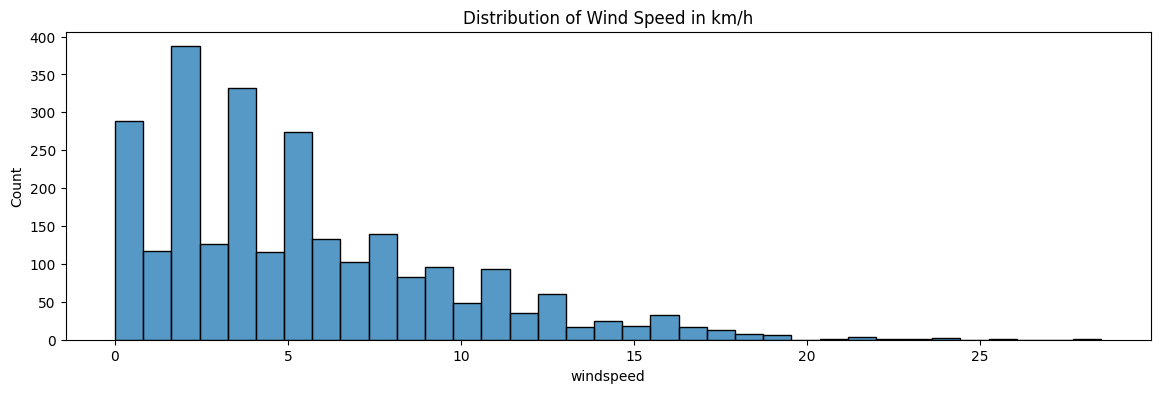

In [10]:
numeric_cols = ['Age_Range','TimeSpent_minutes','buyDrinks','Num_of_Baskets','Temperature','humidity',
                'windspeed','TotalSpent_RM']

fig, ((ax1, ax2)) = plt.subplots(1,2,figsize=(14,4))
fig, ((ax3, ax4)) = plt.subplots(1,2,figsize=(14,4))
fig, ((ax5, ax6)) = plt.subplots(1,2,figsize=(14,4))
fig, ax7 = plt.subplots(1,1,figsize=(14,4))


ax1.set_title("Distribution of Age Range in Years")
ax2.set_title("Distribution of Time Spent in Minutes")
ax3.set_title("Distribution of Number of Bought Drinks")
ax4.set_title("Distribution of Number of Basket")
ax5.set_title("Distribution of Temperature")
ax6.set_title("Distribution of Humidity")
ax7.set_title("Distribution of Wind Speed in km/h")


plotUnivariateFeature('Age_Range',True,df,ax=ax1)
plotUnivariateFeature('TimeSpent_minutes',True,df,ax=ax2)
plotUnivariateFeature('buyDrinks',True,df,ax=ax3)
plotUnivariateFeature('Num_of_Baskets',True,df,ax=ax4)
plotUnivariateFeature('Temperature',True,df,ax=ax5)
plotUnivariateFeature('humidity',True,df,ax=ax6)
plotUnivariateFeature('windspeed',True,df,ax=ax7)

14.0    193
21.0    188
17.0    183
9.0     181
16.0    181
7.0     181
20.0    179
13.0    177
11.0    174
10.0    163
12.0    163
19.0    162
15.0    152
8.0     151
18.0    146
Name: TotalSpent_RM, dtype: int64

<AxesSubplot: title={'center': 'Distribution of Total Money Spent in RM'}, xlabel='TotalSpent_RM', ylabel='count'>

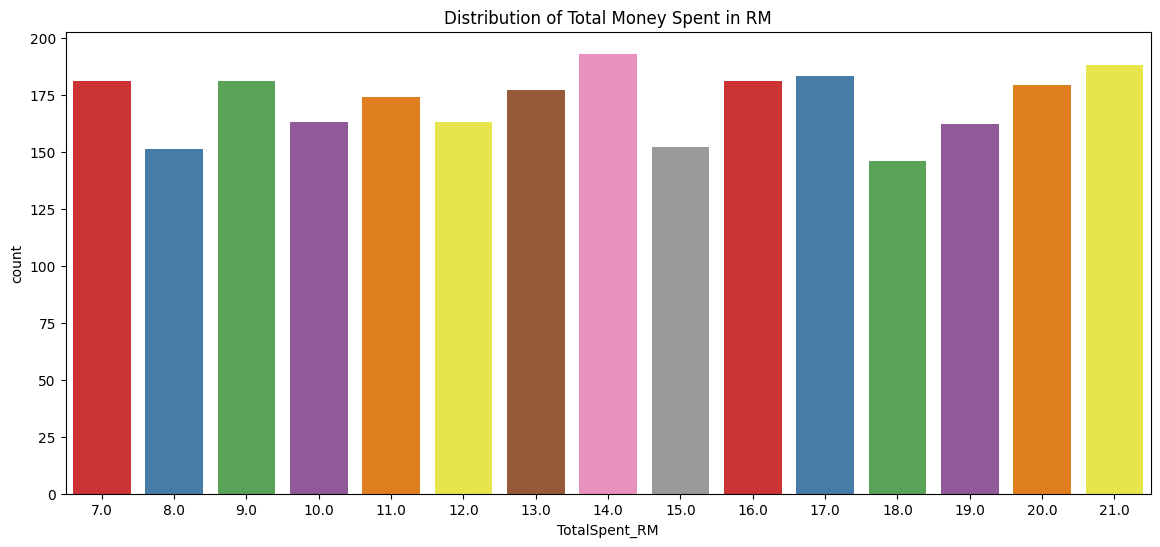

In [11]:
# As we would like to understand what factors contribute to the change of total money spent by customer,
# the target variable is 'TotalSpent_RM'

target = 'TotalSpent_RM'
fig, ax = plt.subplots(1,1,figsize=(14,6))
ax.set_title("Distribution of Total Money Spent in RM")
display(df['TotalSpent_RM'].value_counts())
data = df['TotalSpent_RM']
sns.countplot(x=data, order=sorted(data.unique()), palette=GLOBALPALETTE,ax=ax)

- From the barchart above, we can see that the counts of different values of total money spent are quite balanced

# How does the weather affect the total money spent on average?

In [12]:
df.groupby('isRain')['TotalSpent_RM'].mean()

isRain
False    14.070786
True     13.376923
Name: TotalSpent_RM, dtype: float64

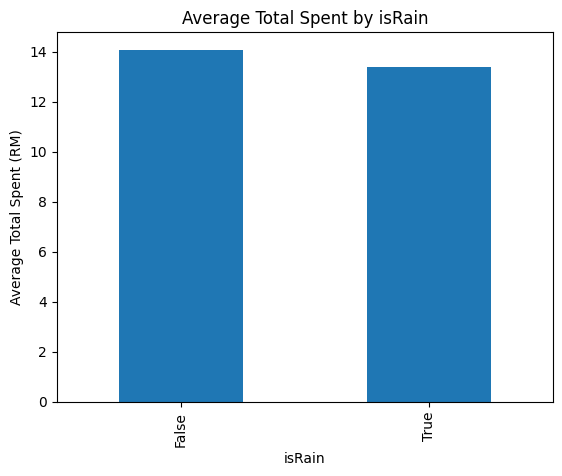

In [13]:
df.groupby('isRain')['TotalSpent_RM'].mean().plot(kind='bar')
plt.xlabel('isRain')
plt.ylabel('Average Total Spent (RM)')
plt.title('Average Total Spent by isRain')
plt.show()

<AxesSubplot: xlabel='Temperature'>

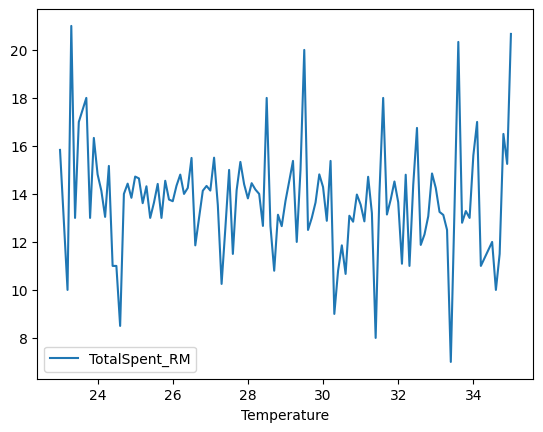

In [14]:
(df.groupby('Temperature')['TotalSpent_RM'].mean().plot(legend=True))

# How does the location of customer affect the total money spent

In [15]:
df.groupby('State')['TotalSpent_RM'].mean()

State
Kuala Lumpur    14.029727
Putrajaya       13.679245
Selangor        14.050000
Name: TotalSpent_RM, dtype: float64

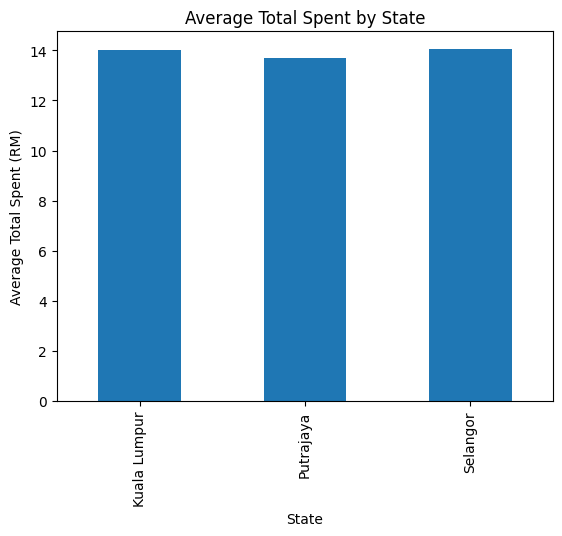

In [16]:
df.groupby('State')['TotalSpent_RM'].mean().plot(kind='bar')
plt.xlabel('State')
plt.ylabel('Average Total Spent (RM)')
plt.title('Average Total Spent by State')
plt.show()

# Clustering
## Customer Segmentation based on Age Range

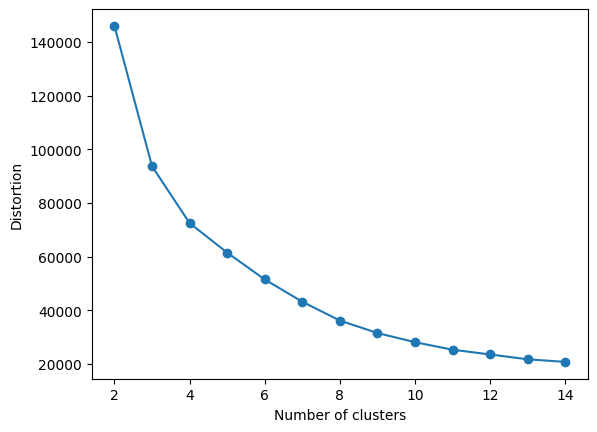

In [17]:
temp = df[['TotalSpent_RM','Age_Range']].copy()

# Using elbow method
distortions = []
list_of_k = range(2, 15)

for i in list_of_k:
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(temp)
    distortions.append(km.inertia_)

# plot
plt.plot(list_of_k, distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

5


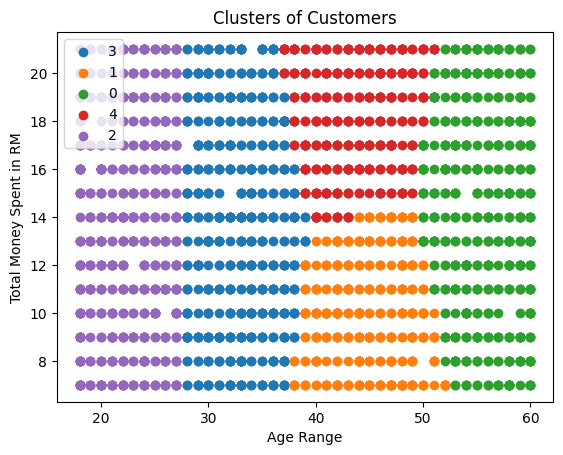

In [18]:
temp = df[['TotalSpent_RM','Age_Range']].copy()

kmeans = KMeans(n_clusters=5, init ='k-means++', max_iter=300, n_init=10,random_state=0 )
kmeans.fit(temp)
temp['label'] = kmeans.labels_
print(temp['label'].nunique())
#plotting the results
# sns.scatterplot(x="temp", y="Age_Range", hue="label", data=temp)

for i in list(temp['label'].unique()):
    data = temp[temp['label'] == i]
    plt.scatter(data['Age_Range'] , data['TotalSpent_RM'] , label = i)
plt.legend()
plt.title('Clusters of Customers')
plt.xlabel('Age Range')
plt.ylabel('Total Money Spent in RM')
plt.show()

In [19]:
import math
high_total_money_spent_customers = temp[temp['label'] == 4]
low_total_money_spent_customers = temp[temp['label'] == 1]
print("Mean Age Range of Customers who spent relatively higher total money: ", math.floor(high_total_money_spent_customers['Age_Range'].mean()))
print("Mean Age Range of Customers who spent relatively lower total money: ", math.floor(low_total_money_spent_customers['Age_Range'].mean()))

Mean Age Range of Customers who spent relatively higher total money:  43
Mean Age Range of Customers who spent relatively lower total money:  45


# Association rule mining
- Use ARM algo (https://stackabuse.com/association-rule-mining-via-apriori-algorithm-in-python/)
- A -> B
    - where A is feature of customer (race, shirt_type and etc) B is either clothes or blankets
    - For example, try to answer what is the race of the customer that has highest likelihood when the clothes or blankets is included

### Data Preprocessing

It requires the dataset to be in the form of a list of lists, where the whole dataset is a big list and each transaction in the dataset is an inner list within the outer big list. 

### Data Cleaning


In [20]:
# Throw Color related cols as it does not represent the types of customer, reducing the time complexity as it is exponential
# Throw DayofWeek, HourInDay as time has too much variables
# Throw State, Postcode as it is redundent
# Throw weather conditions

requiredColumns = ['Race', 'Gender', 'Body_Size', 'Kids_Category', 'Basket_Size', 'Attire', 'Wash_Item', 'Spectacles', 'City']

store_data = df[requiredColumns].copy()

In [21]:
# Set Basket_Size
store_data.loc[store_data["Basket_Size"] == "big", "Basket_Size"] = "big_basket"
store_data.loc[store_data["Basket_Size"] == "small", "Basket_Size"] = "small_basket"

# Set Spectacles
store_data.loc[store_data["Spectacles"] == "yes", "Spectacles"] = "specs"
store_data.loc[store_data["Spectacles"] == "no", "Spectacles"] = "no_specs"

# # Set isRain
# store_data.loc[store_data["isRain"] == True, "isRain"] = "rain"
# store_data.loc[store_data["isRain"] == False, "isRain"] = "no_rain"

In [22]:
store_data.head()


,Race,Gender,Body_Size,Kids_Category,Basket_Size,Attire,Wash_Item,Spectacles,City
0,malay,male,moderate,young,big_basket,casual,clothes,no_specs,Sepang
1,chinese,female,moderate,no_kids,small_basket,casual,clothes,no_specs,Putrajaya
2,chinese,female,thin,no_kids,small_basket,casual,clothes,no_specs,Putrajaya
3,malay,female,fat,no_kids,big_basket,traditional,clothes,specs,Sepang
4,chinese,female,thin,no_kids,big_basket,casual,clothes,no_specs,Putrajaya


In [23]:
records = []
for i in range(2574):
    records.append([str(store_data.values[i,j]) for j in range(len(requiredColumns))])

### Applying Apriori Algorithm

In [24]:
association_rules = apriori(records, min_support=0.0045, min_confidence=0.2, min_lift=3, min_length=2)
association_results = list(association_rules)

### Check the output

In [25]:
print(f'Total number of association results: {len(association_results)}')

print(f'The first association result: {association_results[0]}')

Total number of association results: 389
The first association result: RelationRecord(items=frozenset({'no_kids', 'Putrajaya'}), support=0.017871017871017872, ordered_statistics=[OrderedStatistic(items_base=frozenset({'Putrajaya'}), items_add=frozenset({'no_kids'}), confidence=0.8679245283018868, lift=3.415959840747793)])


### Output in better presentation


Ignore duplicates, https://stackoverflow.com/questions/47928125/removing-inverted-reverse-duplicate-rules-from-apriori-result-in-r

In [26]:
cnt =0
unique_items = set()

for item in association_results:
    # first index of the inner list
    # Contains base item and add item
    pair = item[0] 
    items = [x for x in pair]
    
    if (items[0], items[1]) not in unique_items:
        unique_items.add((items[0], items[1]))
        cnt += 1
        
        print("(Rule " + str(cnt) + ") " + items[0] + " -> " + items[1])

        # second index of the inner list
        print("Support: " + str(round(item[1],3)))

        # third index of the list located at 0th of the third index of the inner list

        print("Confidence: " + str(round(item[2][0][2],4)))
        print("Lift: " + str(round(item[2][0][3],4)))
        print("=====================================")

(Rule 1) no_kids -> Putrajaya
Support: 0.018
Confidence: 0.8679
Lift: 3.416
(Rule 2) big_basket -> Putrajaya
Support: 0.014
Confidence: 0.6981
Lift: 3.7281
(Rule 3) big_basket -> no_kids
Support: 0.015
Confidence: 0.717
Lift: 4.7565
(Rule 4) chinese -> casual
Support: 0.006
Confidence: 0.283
Lift: 3.1266
(Rule 5) clothes -> casual
Support: 0.012
Confidence: 0.6038
Lift: 3.0533
(Rule 6) casual -> no_kids
Support: 0.014
Confidence: 0.6604
Lift: 6.6922
(Rule 7) casual -> no_specs
Support: 0.014
Confidence: 0.6981
Lift: 3.6898
(Rule 8) chinese -> no_kids
Support: 0.005
Confidence: 0.2264
Lift: 3.2022
(Rule 9) clothes -> no_kids
Support: 0.015
Confidence: 0.7358
Lift: 4.9713
(Rule 10) fat -> no_kids
Support: 0.005
Confidence: 0.2642
Lift: 3.6555
(Rule 11) male -> no_kids
Support: 0.009
Confidence: 0.434
Lift: 3.5349
(Rule 12) moderate -> no_kids
Support: 0.007
Confidence: 0.3396
Lift: 3.5392
(Rule 13) no_specs -> no_kids
Support: 0.016
Confidence: 0.7736
Lift: 5.5465
(Rule 14) big_basket ->

### Based on the question, A -> B

Where A is any attribute of the customer, and B is Wash_Item which is either "clothes" or "blankets"

In [27]:
# Print out only associates with clothes or blankets

cnt =0
unique_items = set()

for item in association_results:
    # first index of the inner list
    # Contains base item and add item
    pair = item[0] 
    items = [x for x in pair]
    
    if items[1] not in ["clothes", "blankets"]:
        continue

    if (items[0], items[1]) not in unique_items:
        unique_items.add((items[0], items[1]))
        cnt += 1
        
        print("(Rule " + str(cnt) + ") " + items[0] + " -> " + items[1])

        # second index of the inner list
        print("Support: " + str(round(item[1],3)))

        # third index of the list located at 0th of the third index of the inner list

        print("Confidence: " + str(round(item[2][0][2],4)))
        print("Lift: " + str(round(item[2][0][3],4)))
        print("=====================================")


(Rule 1) moderate -> blankets
Support: 0.005
Confidence: 0.2097
Lift: 3.2318


# Feature Selection
- What are the suitable feature selections techniques to use?
    - Filter method: Pearson Correlation
    - Wrapper method: Boruta algo
    - Embedeed method: Random forest feature importance

In [28]:
features_cols = [
    "Race",
    "Gender",
    "Body_Size",
    "Age_Range",
    "Kids_Category",
    "Basket_Size",
    "Basket_colour",
    "Attire",
    "Shirt_Colour",
    "shirt_type",
    "Pants_Colour",
    "pants_type",
    "Wash_Item",
    "Washer_No",
    "Dryer_No",
    "Spectacles",
    "TimeSpent_minutes",
    "buyDrinks",
    "Num_of_Baskets",
    "City",
    "State",
    "Postcode",
    "Temperature",
    "humidity",
    "windspeed",
    "conditions",
    "isRain",
    "DayOfWeek",
    "HourInDay",
]

# Label encoding
label_encoding_columns = [
    "Race",
    "Gender",
    "Body_Size",
    "Kids_Category",
    "Basket_Size",
    "Basket_colour",
    "Attire",
    "Shirt_Colour",
    "shirt_type",
    "Pants_Colour",
    "pants_type",
    "Wash_Item",
    "Washer_No",
    "Dryer_No",
    "Spectacles",
    "City",
    "State",
    "Postcode",
    "conditions",
    "isRain",
]
target = 'TotalSpent_RM'

df_Re = df.copy()
cols_list = df_Re[label_encoding_columns].columns.to_list()
cols_labelencoder = {}
print(len(cols_list))
for col in cols_list:
    labelencoder = LabelEncoder()
    df_Re[col] = labelencoder.fit_transform(df[col])
    cols_labelencoder[col] = labelencoder 
#     output = open(f'{col}_encoder.pkl', 'wb')
#     pickle.dump(labelencoder, output)

20


In [29]:
len(label_encoding_columns )

20

#### Filter method

,Age_Range,TimeSpent_minutes,buyDrinks,Num_of_Baskets,Temperature,humidity,windspeed,DayOfWeek,HourInDay,TotalSpent_RM
Age_Range,1.000000,0.005600,-0.008833,-0.005591,-0.004638,0.012900,-0.004892,-0.006351,-0.010138,0.031905
TimeSpent_minutes,0.005600,1.000000,-0.014986,0.009127,0.007446,0.007240,-0.004964,-0.039328,0.025997,0.016707
buyDrinks,-0.008833,-0.014986,1.000000,-0.006827,0.006144,-0.015171,0.034066,0.004941,0.013541,-0.025619
Num_of_Baskets,-0.005591,0.009127,-0.006827,1.000000,0.020627,-0.008415,0.006431,0.023460,0.010406,0.041448
Temperature,-0.004638,0.007446,0.006144,0.020627,1.000000,-0.930643,0.575257,-0.022197,0.354436,-0.032101
humidity,0.012900,0.007240,-0.015171,-0.008415,-0.930643,1.000000,-0.550993,0.041526,-0.286833,0.030850
windspeed,-0.004892,-0.004964,0.034066,0.006431,0.575257,-0.550993,1.000000,0.011052,0.339243,-0.040464
DayOfWeek,-0.006351,-0.039328,0.004941,0.023460,-0.022197,0.041526,0.011052,1.000000,-0.039510,0.002608
HourInDay,-0.010138,0.025997,0.013541,0.010406,0.354436,-0.286833,0.339243,-0.039510,1.000000,-0.050610
TotalSpent_RM,0.031905,0.016707,-0.025619,0.041448,-0.032101,0.030850,-0.040464,0.002608,-0.050610,1.000000


<AxesSubplot: >

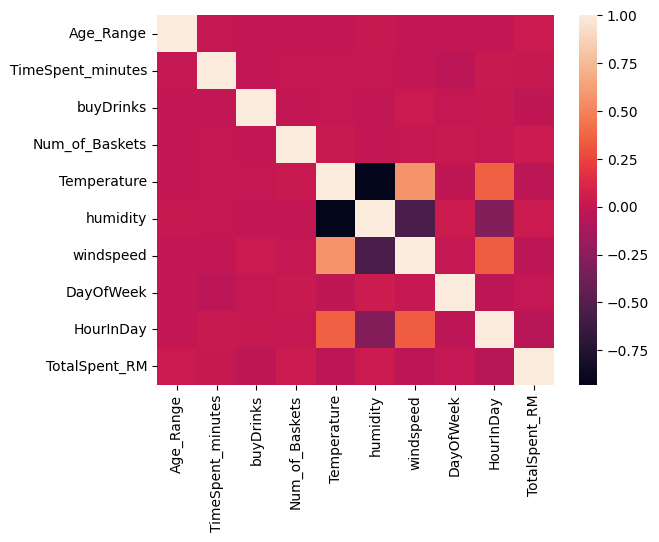

In [30]:
# Filter method for feature selection
# Visualize Pearson correlation between features and target
correlation_cols = [i for i in features_cols.copy() if i not in label_encoding_columns]
correlation_cols.append(target)
corr = df[correlation_cols].corr()
display(corr)
sns.heatmap(corr)

#### Wrapper methods

,Features,Score
23,humidity,1.00
22,Temperature,0.96
3,Age_Range,0.93
24,windspeed,0.89
21,Postcode,0.86
16,TimeSpent_minutes,0.82
28,HourInDay,0.79
10,Pants_Colour,0.79
8,Shirt_Colour,0.71
6,Basket_colour,0.68


Text(0.5, 1.0, 'Boruta all Features')

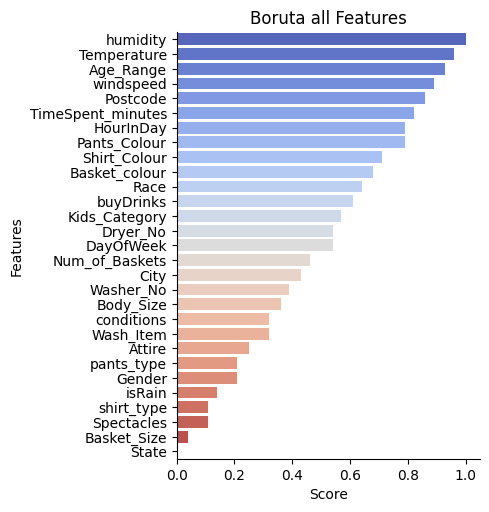

In [31]:
# Wrapper method for feature selection
# Run boruta algo and visualize the ranking of features
def ranking(ranks, names, order=1):
    
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
feat_selector = BorutaPy(rf, n_estimators="auto", random_state=1)
temp_y = df_Re[target]
temp_X = df_Re[features_cols]
colnames = temp_X.columns
feat_selector.fit(temp_X.values, temp_y.values.ravel())
boruta_score = ranking(list(map(float, feat_selector.ranking_)), colnames, order=-1)
boruta_score = pd.DataFrame(list(boruta_score.items()), columns=['Features', 'Score'])
boruta_score = boruta_score.sort_values("Score", ascending = False)
display(boruta_score)
sns_boruta_plot = sns.catplot(x="Score", y="Features", data = boruta_score, kind = "bar", 
                palette='coolwarm')
plt.title("Boruta all Features")


,No_Of_Features,Model,RMSE
0,1,LGBM,4.506766
1,2,LGBM,4.589146
2,3,LGBM,4.738744
3,4,LGBM,4.690439
4,5,LGBM,4.682663
5,6,LGBM,4.692274
6,7,LGBM,4.704349
7,8,LGBM,4.720357
8,9,LGBM,4.645120
9,10,LGBM,4.653633


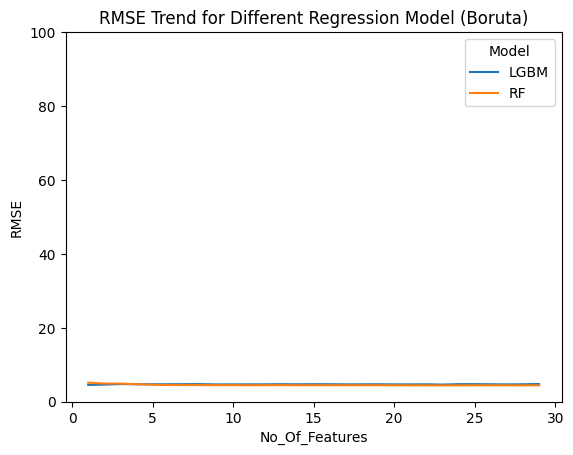

In [32]:
# Display the performance of model when the included features increase based on the ranked order
def get_rmse(y_test,y_pred):
    return np.sqrt(mean_squared_error(y_test,y_pred))

def evaluate_feature_combinations(score_df):
    
    model_list = ["LGBM", "RF"]
    feature_num, rmse_lgbm, rmse_rf = [], [], []

    for i in range(1, len(score_df) + 1):
        feature_num.append(i)
        # Create X and y dataset
        cols = score_df.iloc[:i]['Features'].to_list()
        y = df_Re[target]
        X = df_Re[cols].copy()
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1)
        for model in model_list:
            if model == "LGBM":
                clf = lgb.LGBMRegressor(random_state=42)
            elif model == "RF":
                clf = RandomForestRegressor(random_state=42) 

            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)

            rmse = get_rmse(y_test, y_pred)

            if model == "LGBM":
                rmse_lgbm.append(rmse)
            elif model == "RF":
                rmse_rf.append(rmse) 
                        
    return feature_num, rmse_lgbm, rmse_rf
            
feature_num, rmse_lgbm, rmse_rf = evaluate_feature_combinations(boruta_score)
                            
boruta_rmse_result = pd.DataFrame(list(zip(feature_num,
                                         rmse_lgbm, rmse_rf)),
                                columns = ["No_Of_Features","LGBM","RF"])
boruta_rmse_result1 = pd.melt(boruta_rmse_result,
                           id_vars="No_Of_Features",
                           var_name="Model",value_name="RMSE")

# Plot the line charts
ax = sns.lineplot(x = "No_Of_Features", y = "RMSE", hue = "Model", data = boruta_rmse_result1)
ax.set(ylim=(0, 100))
ax.set(title="RMSE Trend for Different Regression Model (Boruta)")
display(boruta_rmse_result1)

- Increase of number of ranked features only bring very little any difference to the model metrics, whereby indicates not useful for improving model performance

#### Embedded methods

,Features,Importance
23,humidity,0.082522
21,Postcode,0.079547
16,TimeSpent_minutes,0.078806
24,windspeed,0.077371
3,Age_Range,0.076825
22,Temperature,0.060239
28,HourInDay,0.057314
6,Basket_colour,0.049798
10,Pants_Colour,0.048729
8,Shirt_Colour,0.047819


Text(0.5, 9.444444444444438, 'Random Forest Feature Importance')

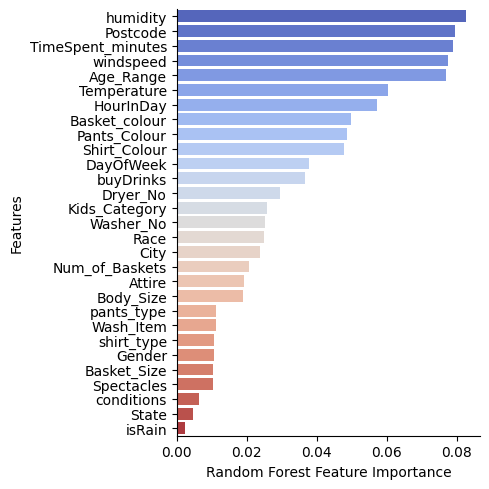

In [33]:
y = df_Re[target]
X = df_Re[features_cols]

rf = RandomForestRegressor(n_estimators = 100, random_state=42)
rf.fit(X, y)
feature_importance_score = pd.DataFrame({
    "Features":X.columns,
   "Importance": rf.feature_importances_  
} )
feature_importance_score = feature_importance_score.sort_values("Importance", ascending = False)
display(feature_importance_score)
sns_boruta_plot = sns.catplot(x="Importance", y="Features", data = feature_importance_score, kind = "bar", 
                palette='coolwarm')
plt.xlabel("Random Forest Feature Importance")



,No_Of_Features,Model,RMSE
0,1,LGBM,4.506766
1,2,LGBM,4.584410
2,3,LGBM,4.601349
3,4,LGBM,4.664241
4,5,LGBM,4.712453
5,6,LGBM,4.692274
6,7,LGBM,4.704349
7,8,LGBM,4.647171
8,9,LGBM,4.667566
9,10,LGBM,4.653633


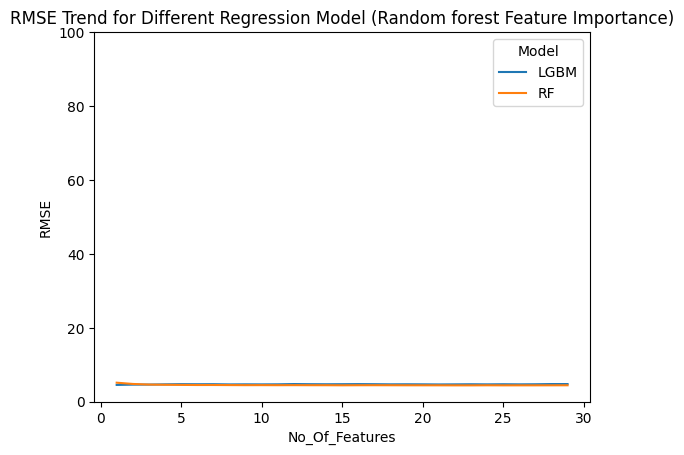

In [34]:
feature_num, rmse_lgbm, rmse_rf = evaluate_feature_combinations(feature_importance_score)
                            
feature_importance_rmse_result = pd.DataFrame(list(zip(feature_num,
                                         rmse_lgbm, rmse_rf)),
                                columns = ["No_Of_Features","LGBM","RF"])
feature_importance_rmse_result1 = pd.melt(feature_importance_rmse_result,
                           id_vars="No_Of_Features",
                           var_name="Model",value_name="RMSE")

# Plot the line charts
ax = sns.lineplot(x = "No_Of_Features", y = "RMSE", hue = "Model", data = feature_importance_rmse_result1)
ax.set(ylim=(0, 100))
ax.set(title="RMSE Trend for Different Regression Model (Random forest Feature Importance)")
display(feature_importance_rmse_result1)

- Increase of number of ranked features only bring very little any difference to the model metrics, whereby indicates not useful for improving model performance

In [35]:
display(boruta_rmse_result1.iloc[boruta_rmse_result1['RMSE'].argmin()])
display(feature_importance_rmse_result1.iloc[feature_importance_rmse_result1['RMSE'].argmin()])


No_Of_Features          23
Model                   RF
RMSE              4.380899
Name: 51, dtype: object

No_Of_Features          23
Model                   RF
RMSE              4.385343
Name: 51, dtype: object

- The methodology here is to check how does the increase of ranked features changes the performance of different regression models from for each feature selection technique
1. Get the set of features that have the best performance from both feature selection techniques
2. Get the intersection of both set of features the overlapped features of both set of features as selected features
3. Compare the model performance using selected features and all features in order to determine the final set of features

# Compare model built using selected features and all features

In [36]:
# Get intersection of both set of best features
boruta_best_n_features = boruta_rmse_result1.iloc[boruta_rmse_result1['RMSE'].argmin()]['No_Of_Features']
rf_feat_importance_best_n_features = feature_importance_rmse_result1.iloc[feature_importance_rmse_result1['RMSE'].argmin()]['No_Of_Features']
selected_features = list(set(feature_importance_score.iloc[:rf_feat_importance_best_n_features]['Features'].to_list()).intersection(set(boruta_score.iloc[:boruta_best_n_features]['Features'].to_list())))
print(len(selected_features))
selected_features

22


['Attire',
 'Washer_No',
 'Body_Size',
 'Kids_Category',
 'Race',
 'TimeSpent_minutes',
 'Dryer_No',
 'DayOfWeek',
 'City',
 'Age_Range',
 'Basket_colour',
 'pants_type',
 'Postcode',
 'Temperature',
 'buyDrinks',
 'Pants_Colour',
 'Wash_Item',
 'windspeed',
 'HourInDay',
 'Shirt_Colour',
 'Num_of_Baskets',
 'humidity']

,RMSE
Selected_Features_LGBM,4.571722
Selected_Features_Random Forest,4.399700
All_Features_LGBM,4.571497
All_Features_Random Forest,4.403521


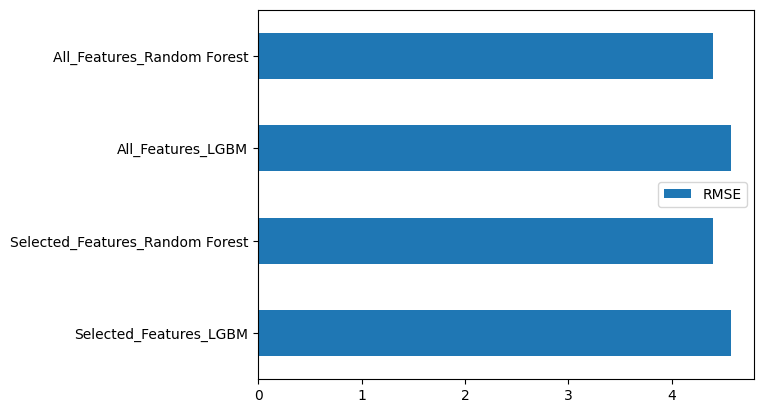

In [37]:
# Put models in a dictionary
models = {"LGBM": lgb.LGBMRegressor(random_state=42), 
          "Random Forest": RandomForestRegressor(random_state=42) ,
         }

def evaluate_with_cv(prefix, models, X, y, scoring="neg_root_mean_squared_error"):
    # Random seed for reproducible results
    np.random.seed(42)
    # Make a list to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():  
        # Evaluate the model and append its means value of model metric value from cross valiation to model_scores
        if prefix:  
            colname = f"{prefix}_{name}"
        else:
            colname = name
        model_scores[colname] = np.mean(-1 * (cross_val_score(model, X, y, scoring=scoring, cv= 5)))
    return model_scores

features = {
    "Selected_Features": selected_features,
    "All_Features": features_cols
}

model_scores = {}
for name, cols in features.items():  
    y = df_Re[target]
    X = df_Re[cols]
    scores = evaluate_with_cv(prefix=name, models=models, X=X, y=y)
    model_scores.update(scores)

model_compare = pd.DataFrame(model_scores, index=['RMSE'])
model_compare.T.plot.barh()
display(model_compare.T)

# Model Construction and Comparison 

- How to validate models? 
    - To minimize sampling bias we can think about k-fold cross validation
- How to compare models
    - Use a common set of model metrics and then 
        - run a stastistical test on the scores from k-fold corss validation to check if there is a statistically significant difference. The result will be a p-value. If that value is lower than 0.05 we can reject the null hypothesis that there are no significant differences between the models. One such method is the Wilcoxon signed-rank test which is the non-parametric version of the paired Student’s t-test. It can be used when the sample size is small and data not following normal distribution
        - Check the average difference of model metrics


# Model comparison

Average difference of the model metrics
----------------------------------------------------------------------------------------
Average difference of MAE  :  0.13577281288095677
Average difference of MSE  :  1.8976478622912405
Average difference of RMSE :  0.21031042793291263


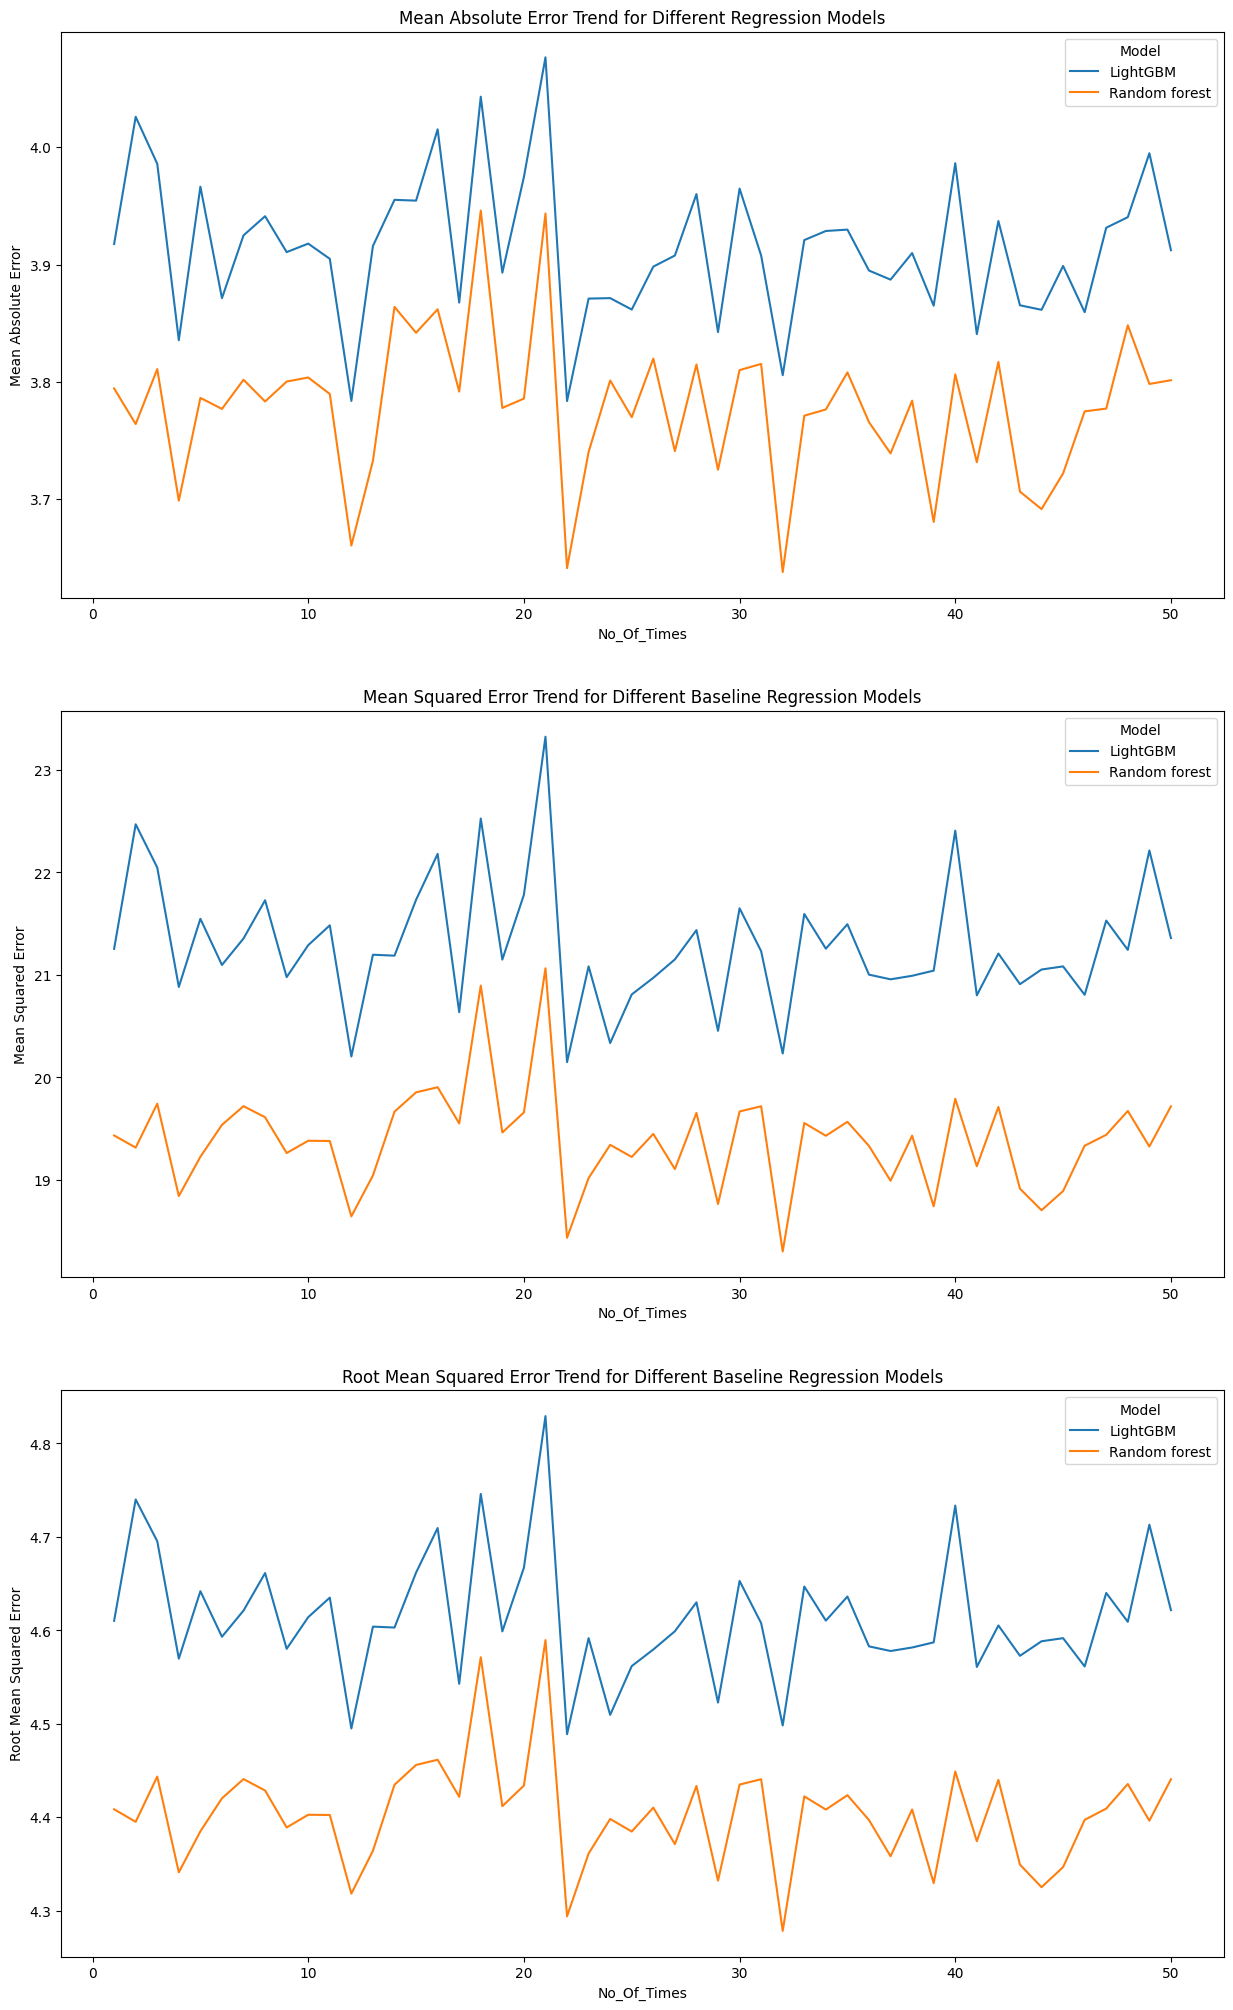

In [38]:
# Perform train-test split see how the model reacts to previously unseen data.

# We can visualize the output of the model by plotting the trend of model metrics of baseline model 
# in multiple iteration. We will start off with baseline model first.

def run_models(models, n_times=50):
    mae_lgbm, mse_lgbm, rmse_lgbm = [], [], []
    mae_rf, mse_rf, rmse_rf = [], [], []
    model = None
    for i in range(n_times):
        y = df_Re[target]
        X = df_Re[features_cols]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=i)
        
        for model_type, model in models.items():  
            if model_type == "LGBM":
                 model = lgb.LGBMRegressor(random_state=42)
            elif model_type == "Random Forest":
                model = RandomForestRegressor(random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mae = mean_absolute_error(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            rmse = get_rmse(y_test, y_pred)
            if model_type == "LGBM":
                mae_lgbm.append(mae)
                mse_lgbm.append(mse)
                rmse_lgbm.append(rmse)
            elif model_type == "Random Forest":
                mae_rf.append(mae)
                mse_rf.append(mse)
                rmse_rf.append(rmse)
            
            
        
    return mae_lgbm, mse_lgbm, rmse_lgbm, mae_rf, mse_rf, rmse_rf

models = {"LGBM": lgb.LGBMRegressor(random_state=42), 
          "Random Forest": RandomForestRegressor(random_state=42),
         }

mae_lgbm, mse_lgbm, rmse_lgbm, mae_rf, mse_rf, rmse_rf = run_models(models)

fig, axes = plt.subplots(3, 1, figsize=(15, 25))
no_of_times = list(range(1, 51))


# MAE
mae_result = pd.DataFrame(
    list(zip(no_of_times, mae_lgbm, mae_rf)),
    columns=[
        "No_Of_Times",
        "LightGBM",
        "Random forest",
    ],
)
mae_result = pd.melt(mae_result, id_vars="No_Of_Times", var_name="Model", value_name="Mean Absolute Error")
sns.lineplot(x="No_Of_Times", y="Mean Absolute Error", hue="Model", data=mae_result, ax=axes[0])
axes[0].set_title("Mean Absolute Error Trend for Different Regression Models")

# MSE
mse_result = pd.DataFrame(
    list(zip(no_of_times, mse_lgbm, mse_rf)),
    columns=[
        "No_Of_Times",
        "LightGBM",
        "Random forest",
    ],
)
mse_result = pd.melt(mse_result, id_vars="No_Of_Times", var_name="Model", value_name="Mean Squared Error")
sns.lineplot(x="No_Of_Times", y="Mean Squared Error", hue="Model", data=mse_result, ax=axes[1])
axes[1].set_title("Mean Squared Error Trend for Different Baseline Regression Models")

# RMSE
rmse_result = pd.DataFrame(
    list(zip(no_of_times, rmse_lgbm, rmse_rf)),
    columns=[
        "No_Of_Times",
        "LightGBM",
        "Random forest",
    ],
)
rmse_result = pd.melt(rmse_result, id_vars="No_Of_Times", var_name="Model", value_name="Root Mean Squared Error")
sns.lineplot(x="No_Of_Times", y="Root Mean Squared Error", hue="Model", data=rmse_result, ax=axes[2])
axes[2].set_title("Root Mean Squared Error Trend for Different Baseline Regression Models")


# Get average difference
def get_avg_diff(list1, list2):
    return ((np.array(list1) - np.array(list2)).mean())

print("Average difference of the model metrics")
print("----------------------------------------------------------------------------------------")
print("Average difference of MAE  : ", get_avg_diff(mae_lgbm, mae_rf))
print("Average difference of MSE  : ", get_avg_diff(mse_lgbm, mse_rf))
print("Average difference of RMSE : ", get_avg_diff(rmse_lgbm, rmse_rf))

- On average, lightgbm model metrics (error) are higher than the random forest, whereby it means lightgbm model performance is worse than random forest model

# Compare difference of model metrics of models using Wilcoxon Test 

In [39]:
# Prepare X and y
y = df_Re[target]
X = df_Re[features_cols]

# Prepare models and select your CV method
model1 = models['LGBM']
model2 = models['Random Forest']
kf = KFold(n_splits=15, shuffle=True, random_state=42)

# Extract results for each model on the same folds
results_model1 = -1 * cross_val_score(model1, X, y, scoring="neg_root_mean_squared_error", cv=kf)
results_model2 = -1 * cross_val_score(model2, X, y, scoring="neg_root_mean_squared_error", cv=kf)

# Calculate p value
stat, p = wilcoxon(results_model1, results_model2, zero_method='zsplit')
print("Average difference of RMSE: ", get_avg_diff(results_model1, results_model2))
print("P-value:", p)

Average difference of RMSE:  0.17566791278096988
P-value: 6.103515625e-05


Since p-value is lower than 0.05 which indicates the difference between RMSE of both models is statistically significant and the average RMSE of random forest is lower, we can conclude that the random forest model is indeed better than lightgbm

# Compare difference of model metrics of Random forest when using Wilcoxon Test on SMOTE dataset and non-SMOTE dataset 

In [40]:
# Prepare SMOTE dataset 
oversample = SMOTE()
smote_X, smote_y = oversample.fit_resample(X, y)

    
# Prepare models and select your CV method
model = RandomForestRegressor(random_state=42)
kf = KFold(n_splits=15, shuffle=True, random_state=42)

# Extract results for each model on the same folds
results_ori_dataset = -1 * cross_val_score(model, X, y, scoring="neg_root_mean_squared_error", cv=kf)
results_smote_dataset = -1 * cross_val_score(model, smote_X, smote_y, scoring="neg_root_mean_squared_error", cv=kf)

# Calculate p value
stat, p = wilcoxon(results_ori_dataset, results_smote_dataset, zero_method='zsplit')
print("Average difference of RMSE: ", get_avg_diff(results_ori_dataset, results_smote_dataset))
print("P-value:", p)

Average difference of RMSE:  0.16910182935228235
P-value: 0.00335693359375


Since p-value is lower than 0.05 which indicates the difference between RMSE of both models that using different dataset is statistically significant, we can infer that using SMOTE data do impact difference of RMSE in a statistically significant way. The average difference is positive, whereby indicates the average RMSE of model that uses SMOTE dataset is lower that model using original dataset. SMOTE will also increase the number of samples in the dataset

-This is the main parameter to control the complexity of the tree model. Theoretically, we can set num_leaves = 2^(max_depth) to obtain the same number of leaves as depth-wise tree. However, this simple conversion is not good in practice. The reason is that a leaf-wise tree is typically much deeper than a depth-wise tree for a fixed number of leaves. Unconstrained depth can induce over-fitting. Thus, when trying to tune the num_leaves, we should let it be smaller than 2^(max_depth). For example, when the max_depth=7 the depth-wise tree can get good accuracy,but setting num_leaves to 127 may cause over-fitting, and setting it to 70 or 80 may get better accuracy than depth-wise.

# Hypeparameter Tuning

In [41]:
# Perform Hyperparameter tuning  using Grid Search with Cross Validation
# We can explicitly specify every combination of settings to try


lightgbm_params_grid = {
    "n_estimators": [20, 30, 100],
    "max_depth": [5, 15],
    "num_leaves": [17, 32741],
    "min_data_in_leaf": [3, 5], 
    "bagging_freq": [1, 5],
}

rf_params_grid = {
    "n_estimators": [20, 30, 100],
    "max_depth": [5, 15],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [3,5],
    'min_samples_split': [5, 10],
}

    

models_dict = {
    "LightGBM":{
        "model":lgb.LGBMRegressor(random_state=42),
        "params_grid": lightgbm_params_grid,
    },
    "Random Forest":{
        "model": RandomForestRegressor(random_state=42),
        "params_grid": rf_params_grid,
    },  
}
    
def tuning_model_parameters(models_dict, scoring):
    y = df_Re[target]
    X = df_Re[features_cols]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1)
    for name, model_info in models_dict.items():  
        model = model_info['model']
        params_grid = model_info['params_grid']
        # Instantiate the grid search model
        grid_search = GridSearchCV(model, params_grid, scoring=scoring, cv = 5)
        best_model = grid_search.fit(X_train, y_train)
        y_pred = best_model.predict(X_test)

        print(f'Best params for {name}', best_model.best_params_)
        print("RMSE:", get_rmse(y_test, y_pred))
    

tuning_model_parameters(models_dict, "neg_root_mean_squared_error")

[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Cu

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Cu

[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Cu

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Cu

[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Cu

[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Cu

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Cu

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max

Best params for Random Forest {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 100}
RMSE: 4.309704863689599


# Model Evaluation

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Cu

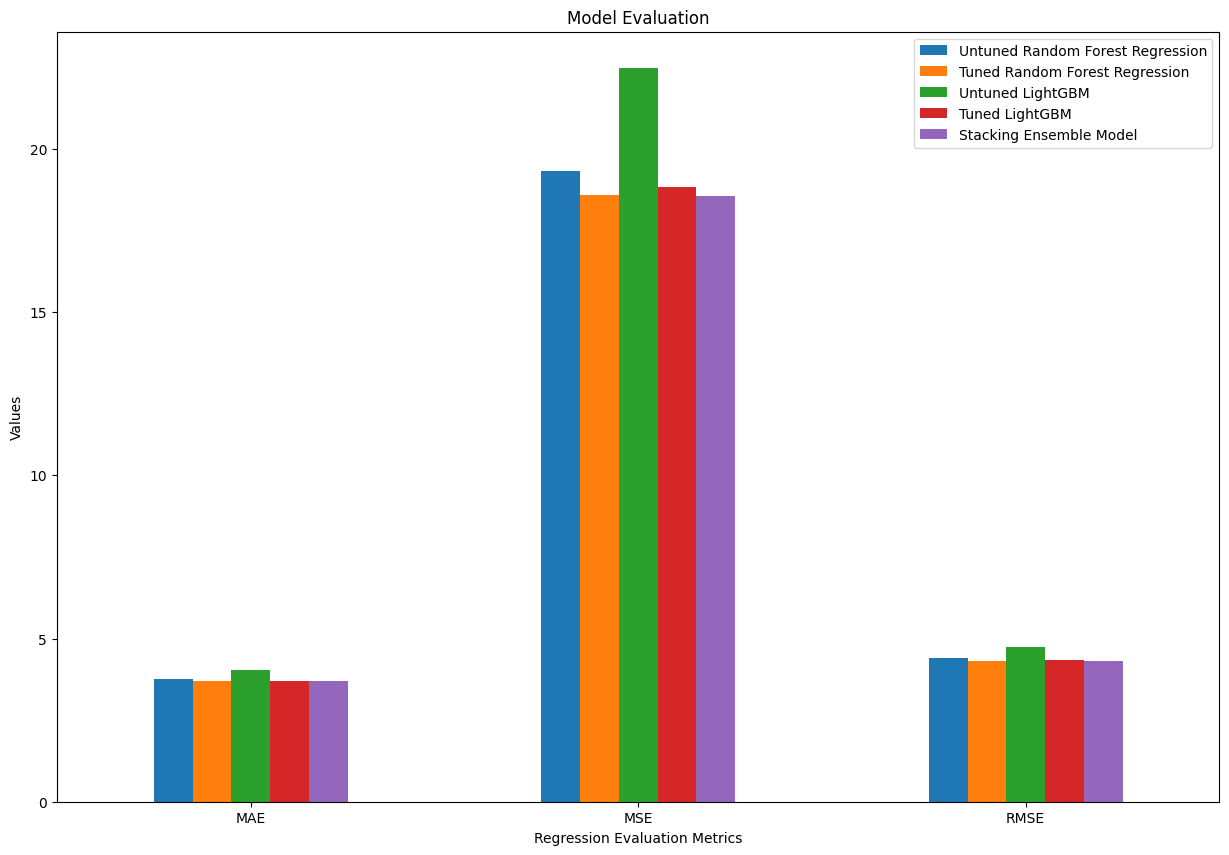

,Untuned Random Forest Regression,Tuned Random Forest Regression,Untuned LightGBM,Tuned LightGBM,Stacking Ensemble Model
MAE,3.764023,3.699893,4.025969,3.712537,3.699728
MSE,19.315774,18.573556,22.467790,18.826083,18.552368
RMSE,4.394971,4.309705,4.740020,4.338903,4.307246


In [42]:
# Compare tuned models with untuned models
best_models = {
    "LightGBM":lgb.LGBMRegressor(
        bagging_freq= 1, max_depth= 15, min_data_in_leaf= 5, n_estimators= 20, num_leaves= 17, random_state=42
    ),
    "Random Forest":RandomForestRegressor(
        max_depth= 5, max_features= 'sqrt', min_samples_leaf= 3, min_samples_split= 5, n_estimators= 100 , random_state=42
    ),
}
# Compare with stacking ensemble model together
def get_stacking():
    level0 = [ ("LightGBM", best_models["LightGBM"])]
    level1 =  best_models["Random Forest"]    
    model = StackingRegressor(estimators=level0, final_estimator=level1)
        
    return model


# Prepare training and testing datasets
y = df_Re[target]
X = df_Re[features_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1)

def train_and_predict(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = get_rmse(y_test, y_pred)
    return [mae,mse,rmse]

# Compute the model metric
untuned_rf = train_and_predict(RandomForestRegressor(random_state=42), X_train, X_test, y_train, y_test)
tuned_rf  = train_and_predict(best_models["Random Forest"] , X_train, X_test, y_train, y_test)
untuned_lgb = train_and_predict(lgb.LGBMRegressor(random_state=42), X_train, X_test, y_train, y_test)
tuned_lgb  = train_and_predict(best_models["LightGBM"], X_train, X_test, y_train, y_test)
stacking  = train_and_predict(get_stacking(), X_train, X_test, y_train, y_test)

# Plot the barchart
result = pd.DataFrame(
    {
        'Untuned Random Forest Regression': untuned_rf , 
        'Tuned Random Forest Regression' :tuned_rf,
        'Untuned LightGBM': untuned_lgb, 
        'Tuned LightGBM' :tuned_lgb,
        "Stacking Ensemble Model": stacking
    }, 
    index=['MAE','MSE','RMSE'])
result.plot(kind='bar', rot=0, figsize=(15,10), title='Model Evaluation')
plt.xlabel('Regression Evaluation Metrics')
plt.ylabel('Values')
plt.show()
display(result)

# Intepret how does the features impact the model

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Cu

Permutation explainer: 774it [03:54,  3.13it/s]                                                                                                 
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


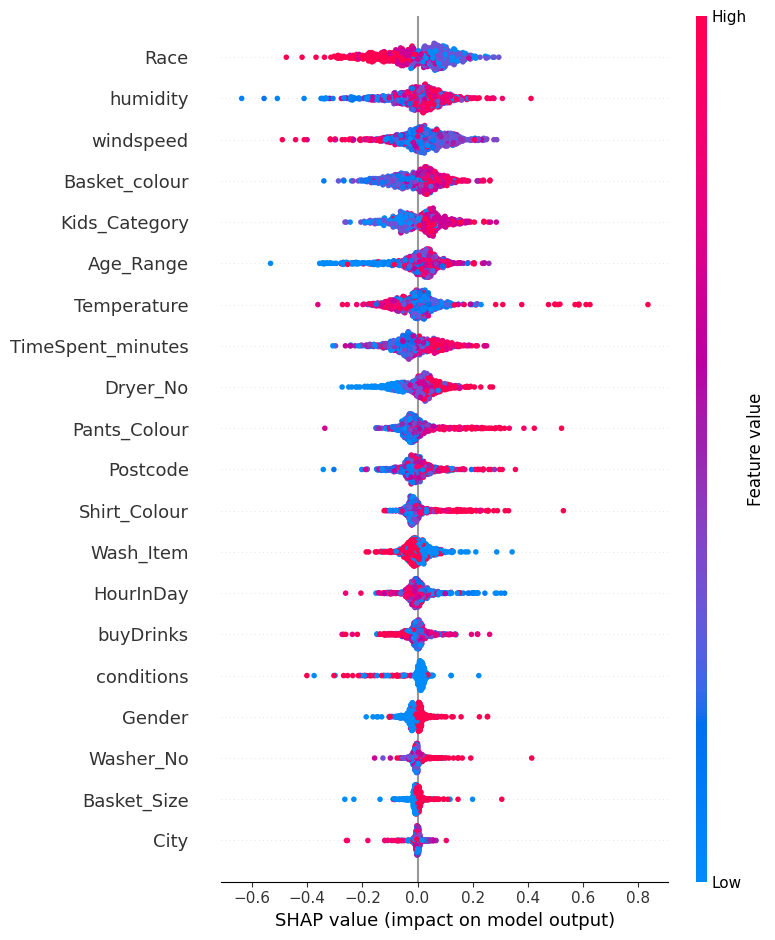

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


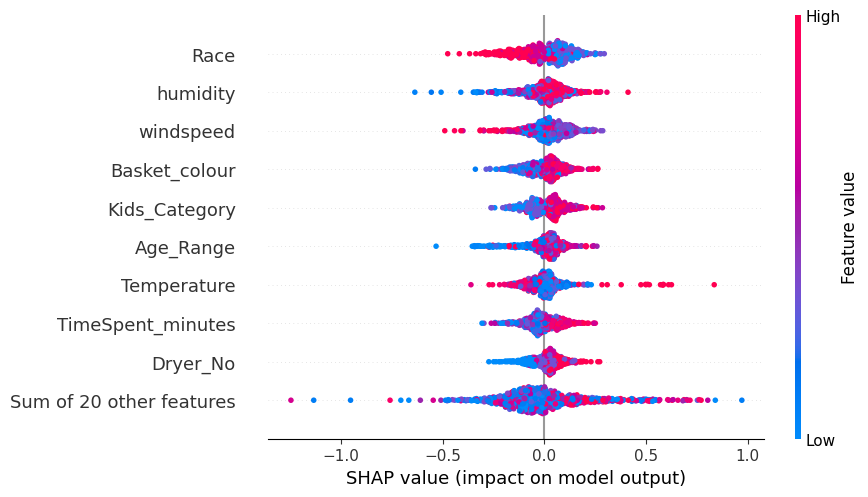

In [43]:
# To intepret how the features impact the model, we will utilize SHAP
# What is the impact of features towards the modeling?
regressor_model = get_stacking()
# Fits the model on the data
regressor_model.fit(X_train, y_train)
# Fits the explainer
explainer = shap.Explainer(regressor_model.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)
shap.summary_plot(shap_values)
shap.plots.beeswarm(shap_values)

In [44]:
# Save model
pickle.dump(regressor_model, open('regressor.pkl', 'wb'))

# Main Question2: What are the frequent types of customer who like to do laundry for blankets or clothes?
# Association rule mining
- Use ARM algo (https://stackabuse.com/association-rule-mining-via-apriori-algorithm-in-python/)
- A -> B
    - where A is feature of customer (race, shirt_type and etc) B is either clothes or blankets
    - For example, try to answer what is the race of the customer that has highest likelihood when the clothes or blankets is included

### Data Preprocessing

It requires the dataset to be in the form of a list of lists, where the whole dataset is a big list and each transaction in the dataset is an inner list within the outer big list. 

In [45]:
# Throw Color related cols as it does not represent the types of customer, reducing the time complexity as it is exponential
# Throw DayofWeek, HourInDay as time has too much variables
# Throw State, Postcode as it is redundent
# Throw weather conditions

requiredColumns = ['Race', 'Gender', 'Body_Size', 'Kids_Category', 'Basket_Size', 'Attire', 'Wash_Item', 'Spectacles', 'City']

store_data = df[requiredColumns].copy()

### Data Cleaning

In [46]:
# Set Basket_Size
store_data.loc[store_data["Basket_Size"] == "big", "Basket_Size"] = "big_basket"
store_data.loc[store_data["Basket_Size"] == "small", "Basket_Size"] = "small_basket"

# Set Spectacles
store_data.loc[store_data["Spectacles"] == "yes", "Spectacles"] = "specs"
store_data.loc[store_data["Spectacles"] == "no", "Spectacles"] = "no_specs"

# # Set isRain
# store_data.loc[store_data["isRain"] == True, "isRain"] = "rain"
# store_data.loc[store_data["isRain"] == False, "isRain"] = "no_rain"

In [47]:
store_data.head()


,Race,Gender,Body_Size,Kids_Category,Basket_Size,Attire,Wash_Item,Spectacles,City
0,malay,male,moderate,young,big_basket,casual,clothes,no_specs,Sepang
1,chinese,female,moderate,no_kids,small_basket,casual,clothes,no_specs,Putrajaya
2,chinese,female,thin,no_kids,small_basket,casual,clothes,no_specs,Putrajaya
3,malay,female,fat,no_kids,big_basket,traditional,clothes,specs,Sepang
4,chinese,female,thin,no_kids,big_basket,casual,clothes,no_specs,Putrajaya


In [48]:
records = []
for i in range(2574):
    records.append([str(store_data.values[i,j]) for j in range(len(requiredColumns))])

### Applying Apriori Algorithm

In [49]:
association_rules = apriori(records, min_support=0.0045, min_confidence=0.2, min_lift=3, min_length=2)
association_results = list(association_rules)

### Check the output

In [50]:
print(f'Total number of association results: {len(association_results)}')

print(f'The first association result: {association_results[0]}')

Total number of association results: 389
The first association result: RelationRecord(items=frozenset({'no_kids', 'Putrajaya'}), support=0.017871017871017872, ordered_statistics=[OrderedStatistic(items_base=frozenset({'Putrajaya'}), items_add=frozenset({'no_kids'}), confidence=0.8679245283018868, lift=3.415959840747793)])


### Output in better presentation


Ignore duplicates, https://stackoverflow.com/questions/47928125/removing-inverted-reverse-duplicate-rules-from-apriori-result-in-r

In [51]:
cnt =0
unique_items = set()

for item in association_results:
    # first index of the inner list
    # Contains base item and add item
    pair = item[0] 
    items = [x for x in pair]
    
    if (items[0], items[1]) not in unique_items:
        unique_items.add((items[0], items[1]))
        cnt += 1
        
        print("(Rule " + str(cnt) + ") " + items[0] + " -> " + items[1])

        # second index of the inner list
        print("Support: " + str(round(item[1],3)))

        # third index of the list located at 0th of the third index of the inner list

        print("Confidence: " + str(round(item[2][0][2],4)))
        print("Lift: " + str(round(item[2][0][3],4)))
        print("=====================================")

(Rule 1) no_kids -> Putrajaya
Support: 0.018
Confidence: 0.8679
Lift: 3.416
(Rule 2) big_basket -> Putrajaya
Support: 0.014
Confidence: 0.6981
Lift: 3.7281
(Rule 3) big_basket -> no_kids
Support: 0.015
Confidence: 0.717
Lift: 4.7565
(Rule 4) chinese -> casual
Support: 0.006
Confidence: 0.283
Lift: 3.1266
(Rule 5) clothes -> casual
Support: 0.012
Confidence: 0.6038
Lift: 3.0533
(Rule 6) casual -> no_kids
Support: 0.014
Confidence: 0.6604
Lift: 6.6922
(Rule 7) casual -> no_specs
Support: 0.014
Confidence: 0.6981
Lift: 3.6898
(Rule 8) chinese -> no_kids
Support: 0.005
Confidence: 0.2264
Lift: 3.2022
(Rule 9) clothes -> no_kids
Support: 0.015
Confidence: 0.7358
Lift: 4.9713
(Rule 10) fat -> no_kids
Support: 0.005
Confidence: 0.2642
Lift: 3.6555
(Rule 11) male -> no_kids
Support: 0.009
Confidence: 0.434
Lift: 3.5349
(Rule 12) moderate -> no_kids
Support: 0.007
Confidence: 0.3396
Lift: 3.5392
(Rule 13) no_specs -> no_kids
Support: 0.016
Confidence: 0.7736
Lift: 5.5465
(Rule 14) big_basket ->

### Based on the question, A -> B

Where A is any attribute of the customer, and B is Wash_Item which is either "clothes" or "blankets"

In [52]:
# Print out only associates with clothes or blankets

cnt =0
unique_items = set()

for item in association_results:
    # first index of the inner list
    # Contains base item and add item
    pair = item[0] 
    items = [x for x in pair]
    
    if items[1] not in ["clothes", "blankets"]:
        continue

    if (items[0], items[1]) not in unique_items:
        unique_items.add((items[0], items[1]))
        cnt += 1
        
        print("(Rule " + str(cnt) + ") " + items[0] + " -> " + items[1])

        # second index of the inner list
        print("Support: " + str(round(item[1],3)))

        # third index of the list located at 0th of the third index of the inner list

        print("Confidence: " + str(round(item[2][0][2],4)))
        print("Lift: " + str(round(item[2][0][3],4)))
        print("=====================================")


(Rule 1) moderate -> blankets
Support: 0.005
Confidence: 0.2097
Lift: 3.2318


# Classification
# Predict wash item

- Then straight to hyperparameter tuning and evaluation between tuned models and untuned models,
- Refer my label encoding code but needs to change the features cols

### Set features and target

In [53]:
# Set Target to "Wash_Item"
target = 'Wash_Item'

features_cols = ['Race', 'Gender', 'Body_Size', 'Age_Range',
                'Kids_Category', 'Basket_Size', 'Basket_colour', 'Attire',
                'Shirt_Colour', 'shirt_type', 'Pants_Colour', 'pants_type', 'TotalSpent_RM',
                'Washer_No', 'Dryer_No', 'Spectacles', 'TimeSpent_minutes', 'buyDrinks',
                'Num_of_Baskets', 'City','State', 'Postcode', 'Temperature', 'humidity', 'windspeed',
                 'conditions', 'isRain', 'DayOfWeek', 'HourInDay'
                ]

### Hypeparameter Tuning

In [54]:
# Perform Hyperparameter tuning  using Grid Search with Cross Validation

# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# var_smoothingfloat, default=1e-9
# Portion of the largest variance of all features that is added to variances for calculation stability.
nb_params_grid = {
    'var_smoothing': np.logspace(0, -9, num=100),
    
}

rf_params_grid = {
    "n_estimators": [20, 30, 100],
    "max_depth": [10, 15],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [3,5],
    'min_samples_split': [5, 10],
}

    

models_dict = {
    "Naive Bayes":{
        "model": GaussianNB(),
        "params_grid": nb_params_grid,
    },
    "Random Forest":{
        "model": RandomForestClassifier(random_state=42),
        "params_grid": rf_params_grid,
    },  
}
    

y = df_Re[target]
X = df_Re[features_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1)
    
def tuning_model_parameters(models_dict, scoring):
    for name, model_info in models_dict.items():  
        model = model_info['model']
        params_grid = model_info['params_grid']
        # Instantiate the grid search model
        grid_search = GridSearchCV(model, params_grid, scoring=scoring, cv = 5)
        best_model = grid_search.fit(X_train, y_train)
        
        y_pred = best_model.predict(X_test)

        print(f'Best params for {name}', best_model.best_params_)
        print("Accuracy = {}".format(round((accuracy_score(y_test, y_pred)*100), 2)))
        print("Recall = {}".format(round((recall_score(y_test, y_pred)*100), 2)))
        print("Precision = {}".format(round((precision_score(y_test, y_pred)*100), 2)))
        print("F1 = {}".format(round((f1_score(y_test, y_pred)*100), 2)))
        print("AUC Score = {}".format(round((roc_auc_score(y_test, y_pred)*100), 2)))

tuning_model_parameters(models_dict, "roc_auc")

Best params for Naive Bayes {'var_smoothing': 0.0006579332246575676}
Accuracy = 54.46
Recall = 77.05
Precision = 55.38
F1 = 64.44
AUC Score = 52.73


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTr

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTr

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTr

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTr

Best params for Random Forest {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 30}
Accuracy = 50.97
Recall = 64.25
Precision = 53.52
F1 = 58.4
AUC Score = 49.95


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


### Model Evaluation

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


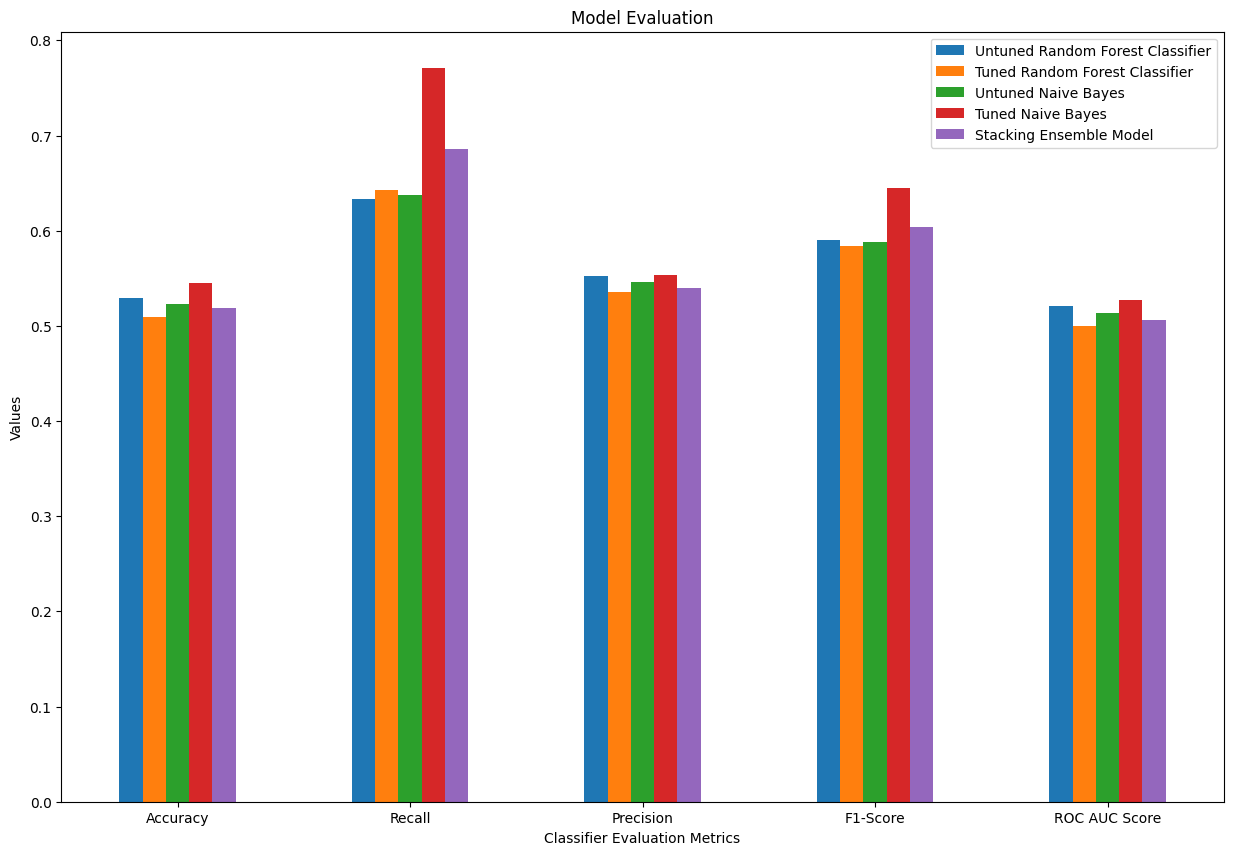

,Untuned Random Forest Classifier,Tuned Random Forest Classifier,Untuned Naive Bayes,Tuned Naive Bayes,Stacking Ensemble Model
Accuracy,0.529107,0.509702,0.522639,0.544631,0.518758
Recall,0.632850,0.642512,0.637681,0.770531,0.685990
Precision,0.552743,0.535211,0.546584,0.553819,0.539924
F1-Score,0.590090,0.583974,0.588629,0.644444,0.604255
ROC AUC Score,0.521160,0.499529,0.513827,0.527327,0.505948


In [55]:
# Compare tuned models with untuned models
best_models = {
    "Naive Bayes":GaussianNB(
        var_smoothing= 0.000657933224657567
    ),
    "Random Forest":RandomForestClassifier(
        max_depth= 10, max_features= 'auto', min_samples_leaf= 5, min_samples_split= 5, n_estimators= 30, random_state=42
    ),
}
# Compare with stacking ensemble model together
def get_stacking():
    level0 = [ ("Naive Bayes", best_models["Naive Bayes"])]
    level1 =  best_models["Random Forest"]    
    model = StackingClassifier(estimators=level0, final_estimator=level1)
        
    return model


# Prepare training and testing datasets
y = df_Re[target]
X = df_Re[features_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1)

def train_and_predict(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)

    return model, [acc, recall, precision, f1, roc]

# Compute the model metric
untuned_rf_model, untuned_rf = train_and_predict(RandomForestClassifier(random_state=42), X_train, X_test, y_train, y_test)
tuned_rf_model, tuned_rf  = train_and_predict(best_models["Random Forest"] , X_train, X_test, y_train, y_test)
untuned_nb_model, untuned_nb = train_and_predict(GaussianNB(), X_train, X_test, y_train, y_test)
tuned_nb_model, tuned_nb  = train_and_predict(best_models["Naive Bayes"], X_train, X_test, y_train, y_test)
stacking_model, stacking  = train_and_predict(get_stacking(), X_train, X_test, y_train, y_test)

# Plot the barchart
result = pd.DataFrame(
    {
        'Untuned Random Forest Classifier': untuned_rf , 
        'Tuned Random Forest Classifier' :tuned_rf,
        'Untuned Naive Bayes': untuned_nb, 
        'Tuned Naive Bayes' :tuned_nb,
        "Stacking Ensemble Model": stacking
    }, 
    index=['Accuracy', 'Recall', 'Precision', 'F1-Score', 'ROC AUC Score'])
result.plot(kind='bar', rot=0, figsize=(15,10), title='Model Evaluation')
plt.xlabel('Classifier Evaluation Metrics')
plt.ylabel('Values')
plt.show()
display(result)

#### 1 is Clothes, 0 is Blankets


In [56]:
print("Encoding")
print(df_Re['Wash_Item'].head())
print("Original")
print(df['Wash_Item'].head())
# cols_labelencoder[col].inverse_transform(df_Re['Wash_Item'])


Encoding
0    1
1    1
2    1
3    1
4    1
Name: Wash_Item, dtype: int64
Original
0    clothes
1    clothes
2    clothes
3    clothes
4    clothes
Name: Wash_Item, dtype: object


### Plot ROC Curve

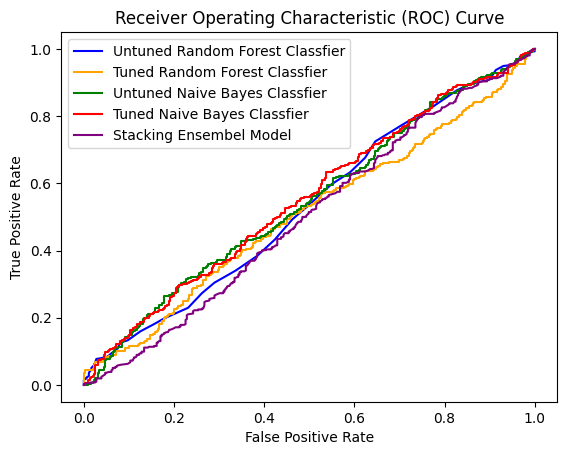

In [57]:
def get_fpr_tpr(model):
    prob = model.predict_proba(X_test)
    prob = prob[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, prob)
    return fpr, tpr

untuned_fpr_rf, untuned_tpr_rf = get_fpr_tpr(untuned_rf_model)
tuned_fpr_rf, tuned_tpr_rf = get_fpr_tpr(tuned_rf_model)
untuned_fpr_nb, untuned_tpr_nb = get_fpr_tpr(untuned_nb_model)
tuned_fpr_nb, tuned_tpr_nb = get_fpr_tpr(tuned_nb_model)
stacking_fpr, stacking_tpr = get_fpr_tpr(stacking_model)

# Plot ROC Curve
plt.plot(untuned_fpr_rf, untuned_tpr_rf, color="blue", label="Untuned Random Forest Classfier")
plt.plot(tuned_fpr_rf, tuned_tpr_rf, color="orange", label="Tuned Random Forest Classfier")
plt.plot(untuned_fpr_nb, untuned_tpr_nb, color="green", label="Untuned Naive Bayes Classfier")
plt.plot(tuned_fpr_nb, tuned_tpr_nb, color="red", label="Tuned Naive Bayes Classfier")
plt.plot(stacking_fpr, stacking_tpr, color="purple", label="Stacking Ensembel Model")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()

- In conclusion
    - For Random Forest Classifier, the tuned model is slightly worse than the untuned model
    - For Naive Bayes, the tuned model outperformed the untuned model by quite a margin
    - Stacking ensemble model does not works the best as the tuned naive bayes model has outperformed stacking ensemble model in every metrics
    - In short, tuned naive bayes model works the best and it will be chosen as final classification model to predict the wash item

In [58]:
# Save model
nb_classifier_model = best_models["Naive Bayes"]
# Fits the model on the data
nb_classifier_model.fit(X_train, y_train)
pickle.dump(nb_classifier_model, open('nb_classifier.pkl', 'wb'))